# Visualization of Platemaps

__Author: Runxi Shen__

__Date: 2025-01-22__

This is a notebook that helps draw up the distribution of alleles and their types on a 384-well platemap to help me better understand the experimental set-ups of different batches and how we need to adjust our analyses pipeline to accommodate the changes accordingly.

In [1]:
import polars as pl
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Disable truncation globally
pl.Config.set_tbl_rows(20)  # Show all rows
pl.Config.set_tbl_cols(40)  # Show all columns

## define control types
TC = ["EGFP"]
NC = ["RHEB", "MAPK9", "PRKACB", "SLIRP"]
PC = ["ALK", "ALK_Arg1275Gln", "PTK2B"]
cNC = ["Renilla"]
cPC = ["KRAS", "PTK2B", "GHSR", "ABL1", "BRD4", "OPRM1", "RB1", "ADA", "WT PMP22", "LYN", "TNF", 
       "CYP2A6", "CSK", "PAK1", "ALDH2", "CHRM3", "KCNQ2", "ALK T1151M", "PRKCE", "LPAR1", "PLP1"]

# CTRLS = TC + NC + PC

## Util functions

__Check the platemap consistency among different replicates (both technical and biological)__

In [2]:
def check_batch_pms(batch_dir):
    platemap_set = sorted(set([platemap_id.split('_T')[0] for platemap_id in os.listdir(batch_dir)]))
    print("Platemaps available for batch:", platemap_set)
    for platemap_id in platemap_set:
        pm_ref_df = pl.read_csv(Path(batch_dir) / Path(platemap_id+"_T1.txt"), separator='\t', has_header=True)
        columns_to_include = pm_ref_df.columns[1:]
        for pm_file in [pm for pm in os.listdir(batch_dir) if platemap_id in pm and "T1" not in pm]:
            pm_df = pl.read_csv(Path(batch_dir) / Path(pm_file), separator='\t', has_header=True)
            df1_selected = pm_ref_df.select(columns_to_include)
            df2_selected = pm_df.select(columns_to_include)
            assert df1_selected.equals(df2_selected)
            print(f"{pm_file} is equal to ref. {platemap_id}_T1.txt")

### Batch 7-8

In [3]:
batch_dir_1 = "../../../8.updated_snakemake_pipeline/inputs/metadata/platemaps/2024_01_23_Batch_7/platemap/"
pm_ref_df_1 = pl.read_csv(Path(batch_dir_1) / Path("B7A1R1_P1.txt"), separator='\t', has_header=True)
batch_dir_2 = "../../../8.updated_snakemake_pipeline/inputs/metadata/platemaps/2024_02_06_Batch_8/platemap/"
pm_ref_df_2 = pl.read_csv(Path(batch_dir_2) / Path("B8A1R2_P1.txt"), separator='\t', has_header=True)
pm_ref_df_1.equals(pm_ref_df_2)

# pm_ref_df_1
# pm_ref_df_2

FileNotFoundError: No such file or directory (os error 2): ...d_snakemake_pipeline/inputs/metadata/platemaps/2024_01_23_Batch_7/platemap/B7A1R1_P1.txt

### Batch 13-14

In [ ]:
batch_dir_1 = "../../../8.updated_snakemake_pipeline/inputs/metadata/platemaps/2025_01_27_Batch_13/platemap/"
pm_ref_df_1 = pl.read_csv(Path(batch_dir_1) / Path("2025_01_27_B13A7A8P1_T1.txt"), separator='\t', has_header=True)
batch_dir_2 = "../../../8.updated_snakemake_pipeline/inputs/metadata/platemaps/2025_01_28_Batch_14/platemap/"
pm_ref_df_2 = pl.read_csv(Path(batch_dir_2) / Path("2025_01_28_B14A7A8P1_T1.txt"), separator='\t', has_header=True)
pm_ref_df_1.equals(pm_ref_df_2)

True

### Plot platemaps in heatmaps

In [4]:
def plot_platemap(df, plate_name):
    # Create a 16x24 grid for the 384-well plate
    rows = list('ABCDEFGHIJKLMNOP')
    cols = [f'{i:02d}' for i in range(1, 25)]
    # Initialize the plate grid with empty values
    plate_grid = pl.DataFrame({col: ['' for _ in rows] for col in cols}, schema={col: pl.Utf8 for col in cols})
    
    # Add a row index to the plate grid
    plate_grid = plate_grid.with_row_index('row')
    # Unpivot the plate grid to long format
    plate_grid = plate_grid.unpivot(index='row', on=cols, variable_name='col', value_name='value')
    
    # Add row and column labels
    plate_grid = plate_grid.with_columns(
        pl.col('row').map_elements(lambda x: rows[x], return_dtype=pl.Utf8).alias('row_label'),  # Map row index to row label (A-P)
        pl.col('col').alias('col_label')  # Use the column name directly as the column label
    )
    # Merge with the input data
    df = df.with_columns(
        pl.col('well_position').str.head(1).alias('row_label'),
        pl.col('well_position').str.slice(1).alias('col_label')
    )
    # Join the input data with the plate grid
    plate_grid = plate_grid.join(df, on=['row_label', 'col_label'], how='left')
    # print(plate_grid.select(pl.col("control_type")).unique())
    # Fill missing values in the gene column
    plate_grid = plate_grid.with_columns(
        pl.col('symbol').fill_null(''),
        pl.col('gene_allele').fill_null(''),
        pl.col('gene_allele').str.replace("_", '\n')
          .alias('label')
    )
    # Reshape the grid for plotting
    # heatmap_data = plate_grid.pivot(index='row_label', columns='col_label', values='color').fill_null('white')
    heatmap_data = plate_grid.pivot(index='row_label', on='col_label', values='label').fill_null('')
    # print(heatmap_data)
    # Assign colors based on conditions
    heatmap_colors = plate_grid.pivot(index='row_label', on='col_label', values='control_type').fill_null('')
    # print(heatmap_colors)

    # Convert to numpy arrays for plotting
    heatmap_labels = heatmap_data[:, 1:].to_numpy()
    heatmap_colors = heatmap_colors[:, 1:].to_numpy()
    # print(heatmap_colors)
    
    # Create a color map for the heatmap
    color_map = {
        '_TC_': 'slategrey', # Grey for controls
        'TC': 'slategrey', # Grey for controls
        'NC': 'gainsboro', 
        'PC': 'plum',
        'cPC': 'pink',
        'allele': 'salmon',  # Tomato for disease
        'disease_wt': 'lightskyblue',  # Skyblue for reference
        '': 'white'  # White for missing wells
    }
    
    # Map the colors to the grid
    heatmap_colors = np.vectorize(color_map.get)(heatmap_colors)
    
    # Plot the heatmap
    plt.figure(figsize=(35, 13.5))
    sns.heatmap(
        np.zeros_like(heatmap_labels, dtype=int),  # Dummy data for heatmap
        annot=heatmap_labels,
        fmt='',
        # cmap='viridis',  # Dummy colormap (not used for coloring)
        cbar=False,
        linewidths=1,
        linecolor='black',
        square=True,
        annot_kws={'size': 8.5, 'color': 'black'}
    )
    
    # Apply colors manually
    for i in range(heatmap_colors.shape[0]):
        for j in range(heatmap_colors.shape[1]):
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, color=heatmap_colors[i, j], fill=True))
    
    # Customize the plot
    plt.title(f"384-Well Plate Map: {plate_name}", fontsize=16)
    plt.xlabel('Columns', fontsize=12)
    plt.ylabel('Rows', fontsize=12)
    plt.xticks(ticks=np.arange(1,25)-.5, labels=cols, rotation=0)
    plt.yticks(ticks=np.arange(16) + 0.5, labels=rows, rotation=0)
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    return plate_grid

## Batch 13/14

In [5]:
# check_batch_pms("/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/inputs/metadata/platemaps/2025_01_27_Batch_13/platemap/")
# check_batch_pms("/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/inputs/metadata/platemaps/2025_01_28_Batch_14/platemap/")

In [6]:
batch_dir_13 = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/inputs/metadata/platemaps/2025_01_27_Batch_13/platemap/"

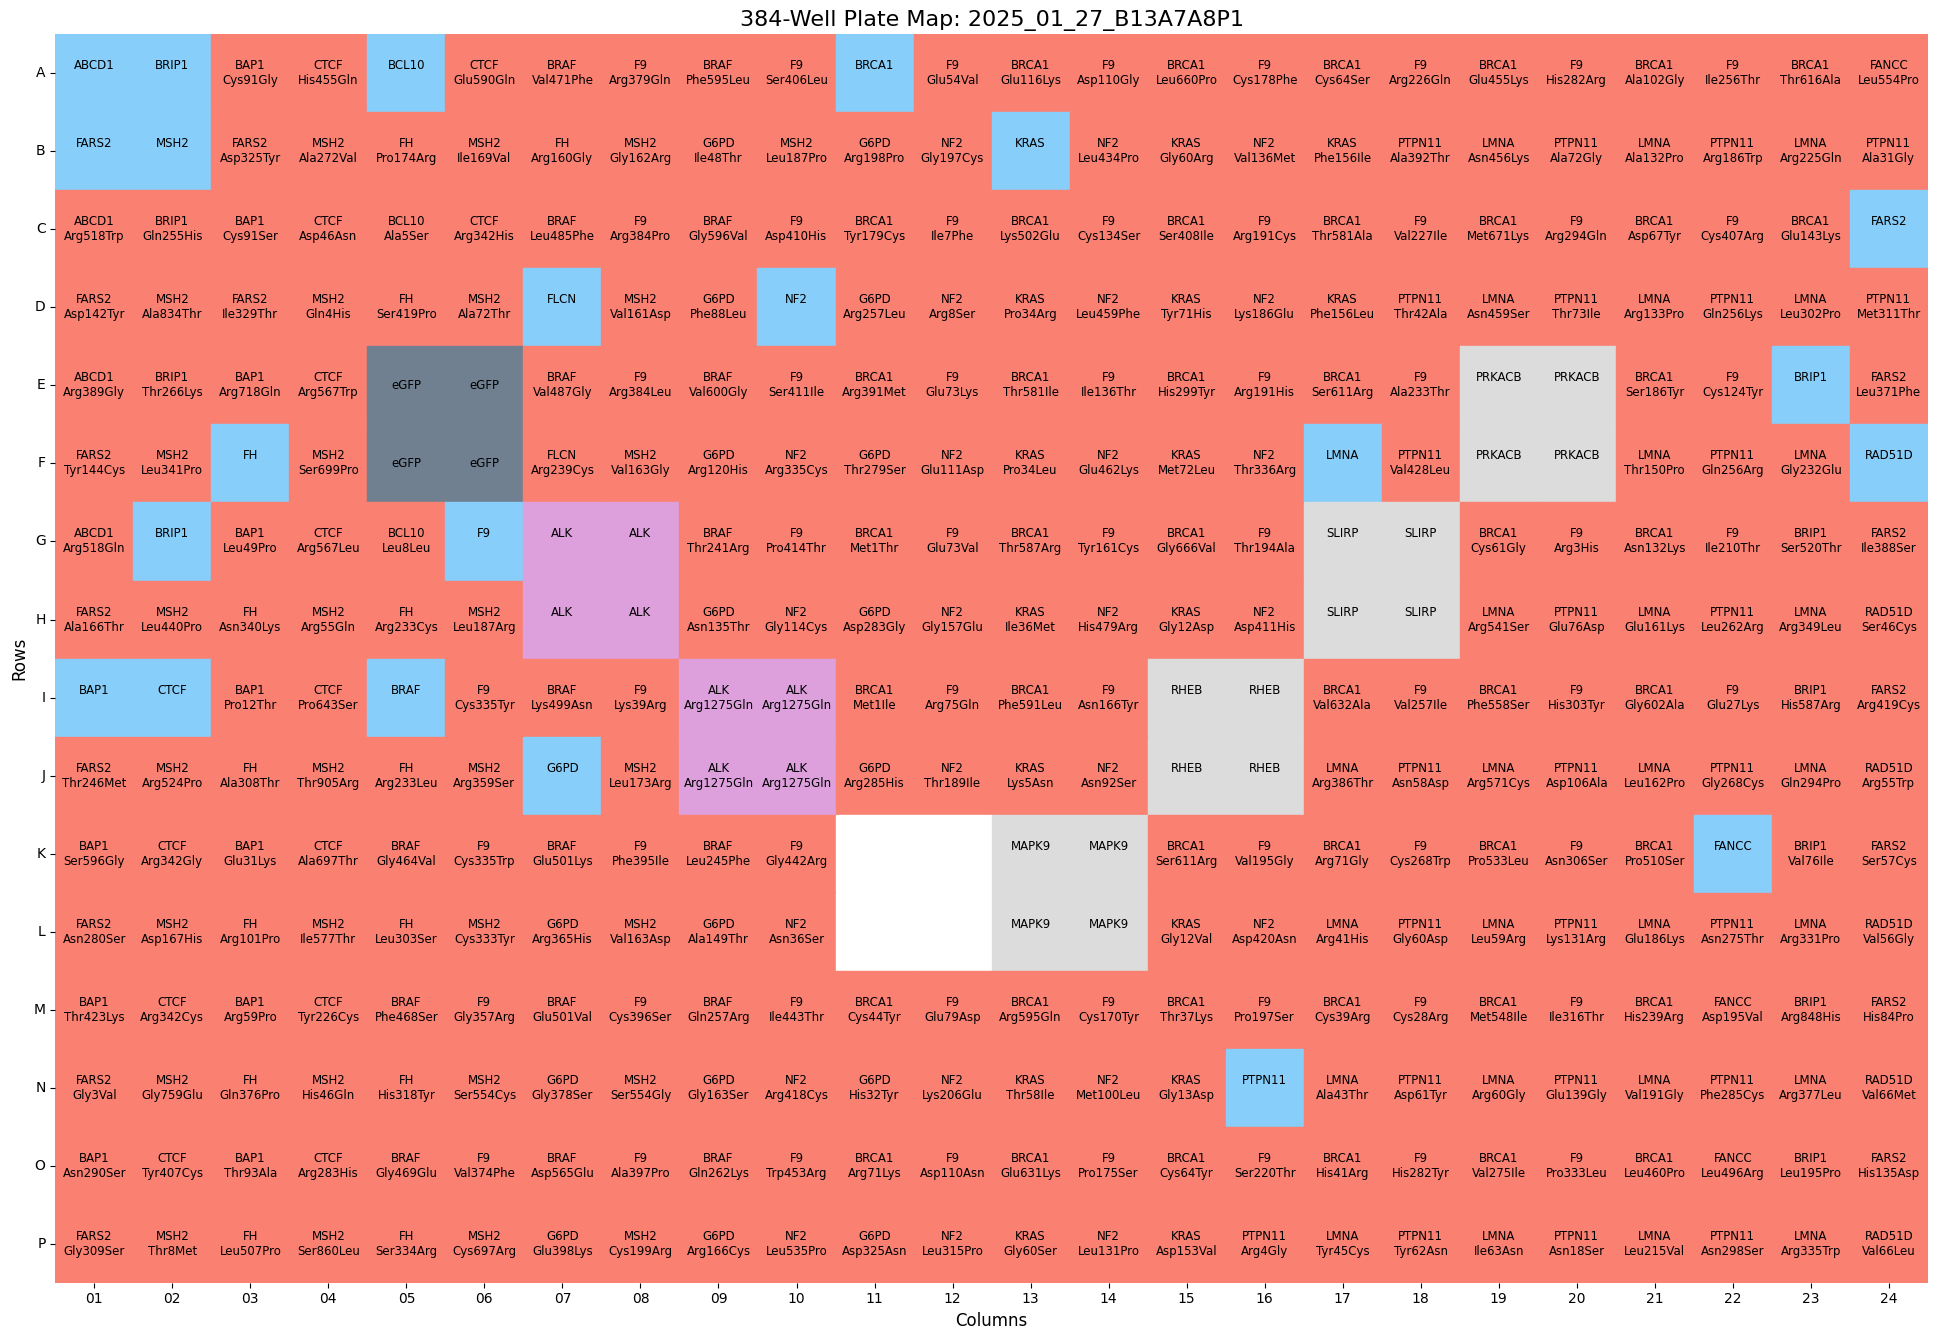

In [7]:
plate_map_id = "B13_B14 Metadata_update.csv"
meta_dat_b134_corrected = pl.read_csv(Path(batch_dir_13) / Path(plate_map_id), separator=',', has_header=True)
# meta_dat_b134_corrected.filter(pl.col("imaging_plate_R1")=="B13A7A8P1_R1")
## Plot first platemap
plate_map = meta_dat_b134_corrected.filter(pl.col("imaging_plate_R1")=="B13A7A8P1_R1").filter(
                ~pl.all_horizontal(pl.all().is_null())
            ).with_columns(pl.col("node_type").alias("control_type"),
                          pl.col("imaging_well").alias("well_position"))
# plate_map
plate_grid = plot_platemap(plate_map, "2025_01_27_B13A7A8P1")

In [13]:
meta_dat_b134_corrected.filter(pl.col("node_type")=="allele") #.select(pl.col("node_type")).unique()

shape: (607, 33)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ sym ┆ gen ┆ sou ┆ sou ┆ sou ┆ des ┆ des ┆ des ┆ ima ┆ ima ┆ ima ┆ nod ┆ orf ┆ ccs ┆ nt_ ┆ aa_ ┆ all ┆ ima ┆ bat ┆ bat ┆ clo ┆ hgm ┆ cli ┆ cli ┆ vec ┆ not ┆ pla ┆ qua ┆ c96 ┆ r96 ┆ r38 ┆ c38 ┆ r38 │
│ bol ┆ e_a ┆ rce ┆ rce ┆ rce ┆ t_p ┆ t_w ┆ t_n ┆ gin ┆ gin ┆ gin ┆ e_t ┆ _id ┆ b_m ┆ cha ┆ cha ┆ ele ┆ gin ┆ ch1 ┆ ch2 ┆ ne_ ┆ d_I ┆ nva ┆ nva ┆ tor ┆ es  ┆ te  ┆ d   ┆ --- ┆ --- ┆ 4   ┆ 4   ┆ 4_l │
│ --- ┆ lle ┆ _pl ┆ _we ┆ _nu ┆ lat ┆ ell ┆ umb ┆ g_w ┆ g_p ┆ g_p ┆ ype ┆ _wt ┆ uta ┆ nge ┆ nge ┆ _se ┆ g_p ┆ --- ┆ --- ┆ ID  ┆ D   ┆ r_a ┆ r_c ┆ --- ┆ --- ┆ --- ┆ --- ┆ i64 ┆ i64 ┆ --- ┆ --- ┆ ett │
│ str ┆ le  ┆ ate ┆ ll  ┆ mb  ┆ e   ┆ --- ┆ --- ┆ ell ┆ lat ┆ lat ┆ --- ┆ --- ┆ tio ┆ _cd ┆ --- ┆ t   ┆ lat ┆ i64 ┆ i64 ┆ --- ┆ --- ┆ lle ┆ lin ┆ i64 ┆ str ┆ i64 ┆ i64 ┆     ┆     ┆ i64 ┆ i64 ┆ er  │
│     ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ str ┆ i64 ┆ --- ┆ e_R ┆ e_R ┆ str ┆ i64 ┆ n_i ┆ na  ┆ str ┆ --- ┆ e   ┆     ┆     ┆ str ┆ str ┆ le_ ┆ ica ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- │
│     ┆ str ┆ str ┆ str ┆ i64 ┆ str ┆     ┆     ┆ str ┆ 1   ┆ 2   ┆     ┆     ┆ d   ┆ --- ┆     ┆ i64 ┆ --- ┆     ┆     ┆     ┆     ┆ ID  ┆ l_s ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆ --- ┆     ┆     ┆ --- ┆ str ┆     ┆     ┆ i64 ┆     ┆     ┆     ┆     ┆ --- ┆ ign ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆ str ┆     ┆     ┆ str ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆ ifi ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ can ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ ce  ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╡
│ ABC ┆ ABC ┆ CP_ ┆ B01 ┆ 2   ┆ 527 ┆ B01 ┆ 2   ┆ C01 ┆ B13 ┆ B14 ┆ all ┆ 100 ┆ CCS ┆ 155 ┆ Arg ┆ 7   ┆ 1   ┆ 13  ┆ 14  ┆ nul ┆ nul ┆ nul ┆ nul ┆ 527 ┆ nul ┆ 1   ┆ 1   ┆ 1   ┆ 2   ┆ 3   ┆ 1   ┆ C   │
│ D1  ┆ D1_ ┆ CAV ┆     ┆     ┆ _CA ┆     ┆     ┆     ┆ A7A ┆ A7A ┆ ele ┆ 008 ┆ BVa ┆ 2C> ┆ 518 ┆     ┆     ┆     ┆     ┆ l   ┆ l   ┆ l   ┆ l   ┆     ┆ l   ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆ Arg ┆ A_0 ┆     ┆     ┆ VA_ ┆     ┆     ┆     ┆ 8P1 ┆ 8P1 ┆     ┆ 637 ┆ rC0 ┆ T   ┆ Trp ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆ 518 ┆ 1   ┆     ┆     ┆ Arr ┆     ┆     ┆     ┆ _R1 ┆ _R2 ┆     ┆     ┆ 070 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆ Trp ┆     ┆     ┆     ┆ ay_ ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ 22  ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆ P01 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆  

In [31]:
result_count = plate_map.to_pandas().groupby(['node_type', 'gene_allele']).size().reset_index(name='count')
result_count[result_count["node_type"]=="allele"]

node_type      gene_allele  count
7      allele  ABCD1_Arg389Gly      1
8      allele  ABCD1_Arg518Gln      1
9      allele  ABCD1_Arg518Trp      1
10     allele    BAP1_Arg59Pro      1
11     allele   BAP1_Arg718Gln      1
..        ...              ...    ...
331    allele  RAD51D_Arg55Trp      1
332    allele  RAD51D_Ser46Cys      1
333    allele  RAD51D_Val56Gly      1
334    allele  RAD51D_Val66Leu      1
335    allele  RAD51D_Val66Met      1

[329 rows x 3 columns]

In [8]:
plate_map.filter(pl.col("symbol")=="BRIP1")

shape: (10, 35)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ sym ┆ gen ┆ sou ┆ sou ┆ sou ┆ des ┆ des ┆ des ┆ ima ┆ ima ┆ ima ┆ nod ┆ orf ┆ ccs ┆ nt_ ┆ aa_ ┆ all ┆ ima ┆ bat ┆ bat ┆ clo ┆ hgm ┆ cli ┆ cli ┆ vec ┆ not ┆ pla ┆ qua ┆ c96 ┆ r96 ┆ r38 ┆ c38 ┆ r38 ┆ con ┆ wel │
│ bol ┆ e_a ┆ rce ┆ rce ┆ rce ┆ t_p ┆ t_w ┆ t_n ┆ gin ┆ gin ┆ gin ┆ e_t ┆ _id ┆ b_m ┆ cha ┆ cha ┆ ele ┆ gin ┆ ch1 ┆ ch2 ┆ ne_ ┆ d_I ┆ nva ┆ nva ┆ tor ┆ es  ┆ te  ┆ d   ┆ --- ┆ --- ┆ 4   ┆ 4   ┆ 4_l ┆ tro ┆ l_p │
│ --- ┆ lle ┆ _pl ┆ _we ┆ _nu ┆ lat ┆ ell ┆ umb ┆ g_w ┆ g_p ┆ g_p ┆ ype ┆ _wt ┆ uta ┆ nge ┆ nge ┆ _se ┆ g_p ┆ --- ┆ --- ┆ ID  ┆ D   ┆ r_a ┆ r_c ┆ --- ┆ --- ┆ --- ┆ --- ┆ i64 ┆ i64 ┆ --- ┆ --- ┆ ett ┆ l_t ┆ osi │
│ str ┆ le  ┆ ate ┆ ll  ┆ mb  ┆ e   ┆ --- ┆ --- ┆ ell ┆ lat ┆ lat ┆ --- ┆ --- ┆ tio ┆ _cd ┆ --- ┆ t   ┆ lat ┆ i64 ┆ i64 ┆ --- ┆ --- ┆ lle ┆ lin ┆ i64 ┆ str ┆ i64 ┆ i64 ┆     ┆     ┆ i64 ┆ i64 ┆ er  ┆ ype ┆ tio │
│     ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ str ┆ i64 ┆ --- ┆ e_R ┆ e_R ┆ str ┆ i64 ┆ n_i ┆ na  ┆ str ┆ --- ┆ e   ┆     ┆     ┆ str ┆ str ┆ le_ ┆ ica ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆ --- ┆ n   │
│     ┆ str ┆ str ┆ str ┆ i64 ┆ str ┆     ┆     ┆ str ┆ 1   ┆ 2   ┆     ┆     ┆ d   ┆ --- ┆     ┆ i64 ┆ --- ┆     ┆     ┆     ┆     ┆ ID  ┆ l_s ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆ str ┆ --- │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆ --- ┆     ┆     ┆ --- ┆ str ┆     ┆     ┆ i64 ┆     ┆     ┆     ┆     ┆ --- ┆ ign ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆ str ┆     ┆     ┆ str ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆ ifi ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ can ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ ce  ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╡
│ BRI ┆ BRI ┆ GDE ┆ E06 ┆ 45  ┆ 527 ┆ C12 ┆ 91  ┆ E23 ┆ B13 ┆ B14 ┆ dis ┆ 551 ┆ nul ┆ nul ┆ nul ┆ 7   ┆ 1   ┆ 13  ┆ 14  ┆ nul ┆ nul ┆ nul ┆ nul ┆ 527 ┆ nul ┆ 1   ┆ 1   ┆ 12  ┆ 3   ┆ 5   ┆ 23  ┆ E   ┆ dis ┆ E23 │
│ P1  ┆ P1_ ┆ hVC ┆     ┆     ┆ _CA ┆     ┆     ┆     ┆ A7A ┆ A7A ┆ eas ┆ 28  ┆ l   ┆ l   ┆ l   ┆     ┆     ┆     ┆     ┆ l   ┆ l   ┆ l   ┆ l   ┆     ┆ l   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ eas ┆     │
│     ┆     ┆ _CA ┆     ┆     ┆ VA_ ┆     ┆     ┆     ┆ 8P1 ┆ 8P1 ┆ e_w ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ e_w ┆     │
│     ┆     ┆ VA_ ┆     ┆     ┆ Arr ┆     ┆     ┆     ┆ _R1 ┆ _R2 ┆ t   ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ t   ┆     │
│     ┆     ┆ FNA ┆     ┆     ┆ ay_ ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     

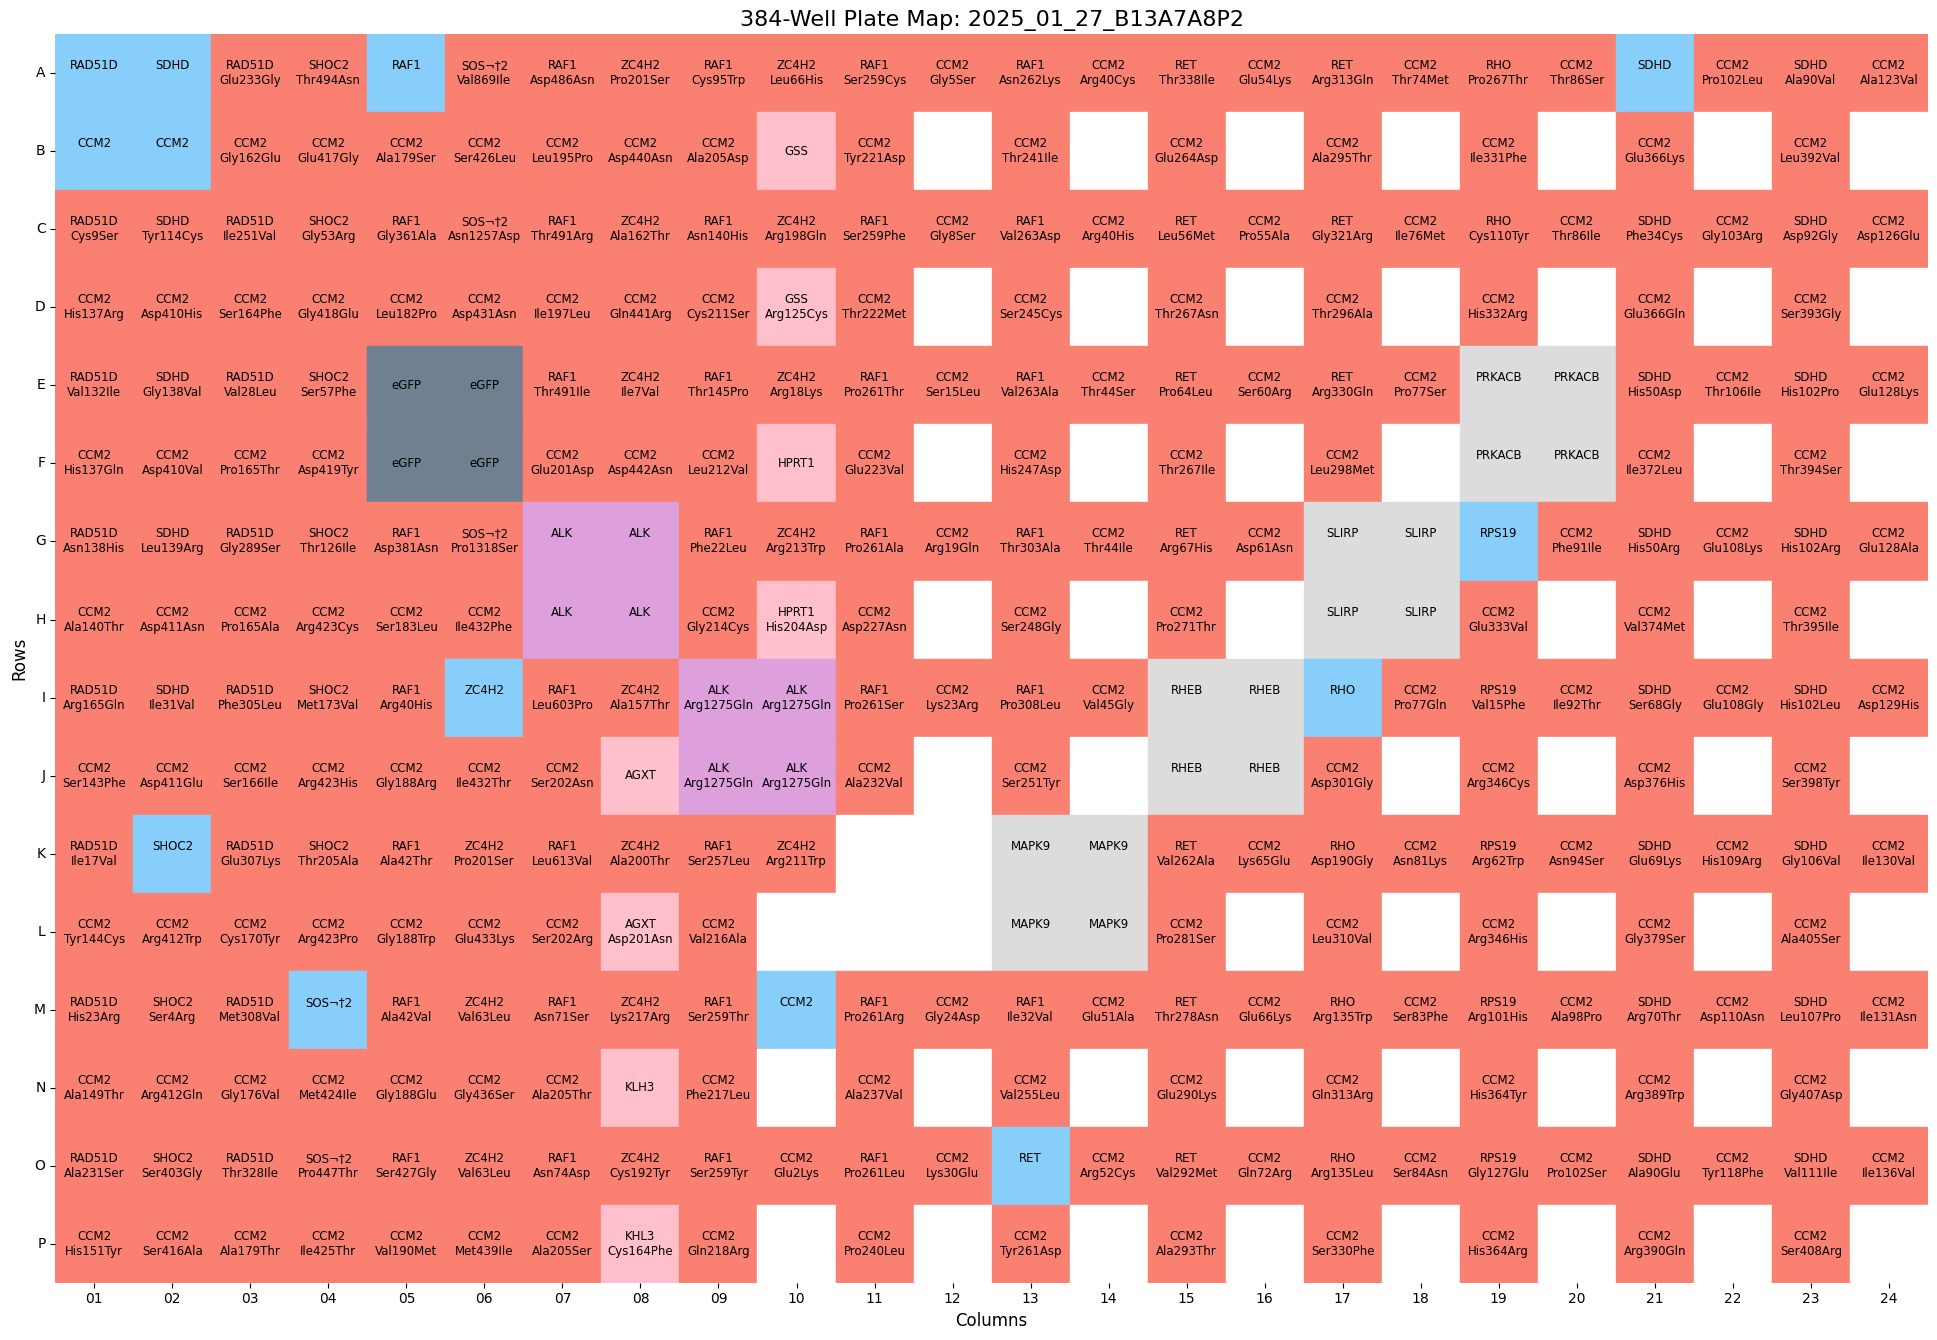

node_type      gene_allele  count
7      allele   CCM2_Ala123Val      1
8      allele   CCM2_Ala140Thr      1
9      allele   CCM2_Ala149Thr      1
10     allele   CCM2_Ala179Ser      1
11     allele   CCM2_Ala179Thr      1
..        ...              ...    ...
277    allele    ZC4H2_Ile7Val      1
278    allele   ZC4H2_Leu66His      1
279    allele  ZC4H2_Lys217Arg      1
280    allele  ZC4H2_Pro201Ser      2
281    allele   ZC4H2_Val63Leu      2

[275 rows x 3 columns]

In [32]:
# meta_dat_b134_corrected.filter(pl.col("imaging_plate_R1")=="B13A7A8P2_R1")
plate_map = meta_dat_b134_corrected.filter(pl.col("imaging_plate_R1")=="B13A7A8P2_R1").filter(
                ~pl.all_horizontal(pl.all().is_null())
            ).with_columns(pl.col("node_type").alias("control_type"),
                          pl.col("imaging_well").alias("well_position"))
# plate_map
plate_grid = plot_platemap(plate_map, "2025_01_27_B13A7A8P2")

result_count = plate_map.to_pandas().groupby(['node_type', 'gene_allele']).size().reset_index(name='count')
result_count[result_count["node_type"]=="allele"]

In [33]:
275+329

604

In [13]:
meta_dat_b134_corrected.filter(pl.col("symbol")=="eGFP")

shape: (8, 33)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ sym ┆ gen ┆ sou ┆ sou ┆ sou ┆ des ┆ des ┆ des ┆ ima ┆ ima ┆ ima ┆ nod ┆ orf ┆ ccs ┆ nt_ ┆ aa_ ┆ all ┆ ima ┆ bat ┆ bat ┆ clo ┆ hgm ┆ cli ┆ cli ┆ vec ┆ not ┆ pla ┆ qua ┆ c96 ┆ r96 ┆ r38 ┆ c38 ┆ r38 │
│ bol ┆ e_a ┆ rce ┆ rce ┆ rce ┆ t_p ┆ t_w ┆ t_n ┆ gin ┆ gin ┆ gin ┆ e_t ┆ _id ┆ b_m ┆ cha ┆ cha ┆ ele ┆ gin ┆ ch1 ┆ ch2 ┆ ne_ ┆ d_I ┆ nva ┆ nva ┆ tor ┆ es  ┆ te  ┆ d   ┆ --- ┆ --- ┆ 4   ┆ 4   ┆ 4_l │
│ --- ┆ lle ┆ _pl ┆ _we ┆ _nu ┆ lat ┆ ell ┆ umb ┆ g_w ┆ g_p ┆ g_p ┆ ype ┆ _wt ┆ uta ┆ nge ┆ nge ┆ _se ┆ g_p ┆ --- ┆ --- ┆ ID  ┆ D   ┆ r_a ┆ r_c ┆ --- ┆ --- ┆ --- ┆ --- ┆ i64 ┆ i64 ┆ --- ┆ --- ┆ ett │
│ str ┆ le  ┆ ate ┆ ll  ┆ mb  ┆ e   ┆ --- ┆ --- ┆ ell ┆ lat ┆ lat ┆ --- ┆ --- ┆ tio ┆ _cd ┆ --- ┆ t   ┆ lat ┆ i64 ┆ i64 ┆ --- ┆ --- ┆ lle ┆ lin ┆ i64 ┆ str ┆ i64 ┆ i64 ┆     ┆     ┆ i64 ┆ i64 ┆ er  │
│     ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ str ┆ i64 ┆ --- ┆ e_R ┆ e_R ┆ str ┆ i64 ┆ n_i ┆ na  ┆ str ┆ --- ┆ e   ┆     ┆     ┆ str ┆ str ┆ le_ ┆ ica ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- │
│     ┆ str ┆ str ┆ str ┆ i64 ┆ str ┆     ┆     ┆ str ┆ 1   ┆ 2   ┆     ┆     ┆ d   ┆ --- ┆     ┆ i64 ┆ --- ┆     ┆     ┆     ┆     ┆ ID  ┆ l_s ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆ --- ┆     ┆     ┆ --- ┆ str ┆     ┆     ┆ i64 ┆     ┆     ┆     ┆     ┆ --- ┆ ign ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆ str ┆     ┆     ┆ str ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆ ifi ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ can ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ ce  ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ --- ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆ str ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╡
│ eGF ┆ eGF ┆ 561 ┆ nul ┆ nul ┆ 527 ┆ C03 ┆ 19  ┆ E05 ┆ B13 ┆ B14 ┆ TC  ┆ nul ┆ nul ┆ nul ┆ nul ┆ 7   ┆ 1   ┆ 13  ┆ 14  ┆ nul ┆ nul ┆ nul ┆ nul ┆ 561 ┆ nul ┆ 1   ┆ 1   ┆ 3   ┆ 3   ┆ 5   ┆ 5   ┆ E   │
│ P   ┆ P   ┆ Con ┆ l   ┆ l   ┆ _CA ┆     ┆     ┆     ┆ A7A ┆ A7A ┆     ┆ l   ┆ l   ┆ l   ┆ l   ┆     ┆     ┆     ┆     ┆ l   ┆ l   ┆ l   ┆ l   ┆     ┆ l   ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆ tro ┆     ┆     ┆ VA_ ┆     ┆     ┆     ┆ 8P1 ┆ 8P1 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆ ls  ┆     ┆     ┆ Arr ┆     ┆     ┆     ┆ _R1 ┆ _R2 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆ ay_ ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     │
│     ┆     ┆     ┆     ┆     ┆ P01 ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆     ┆    

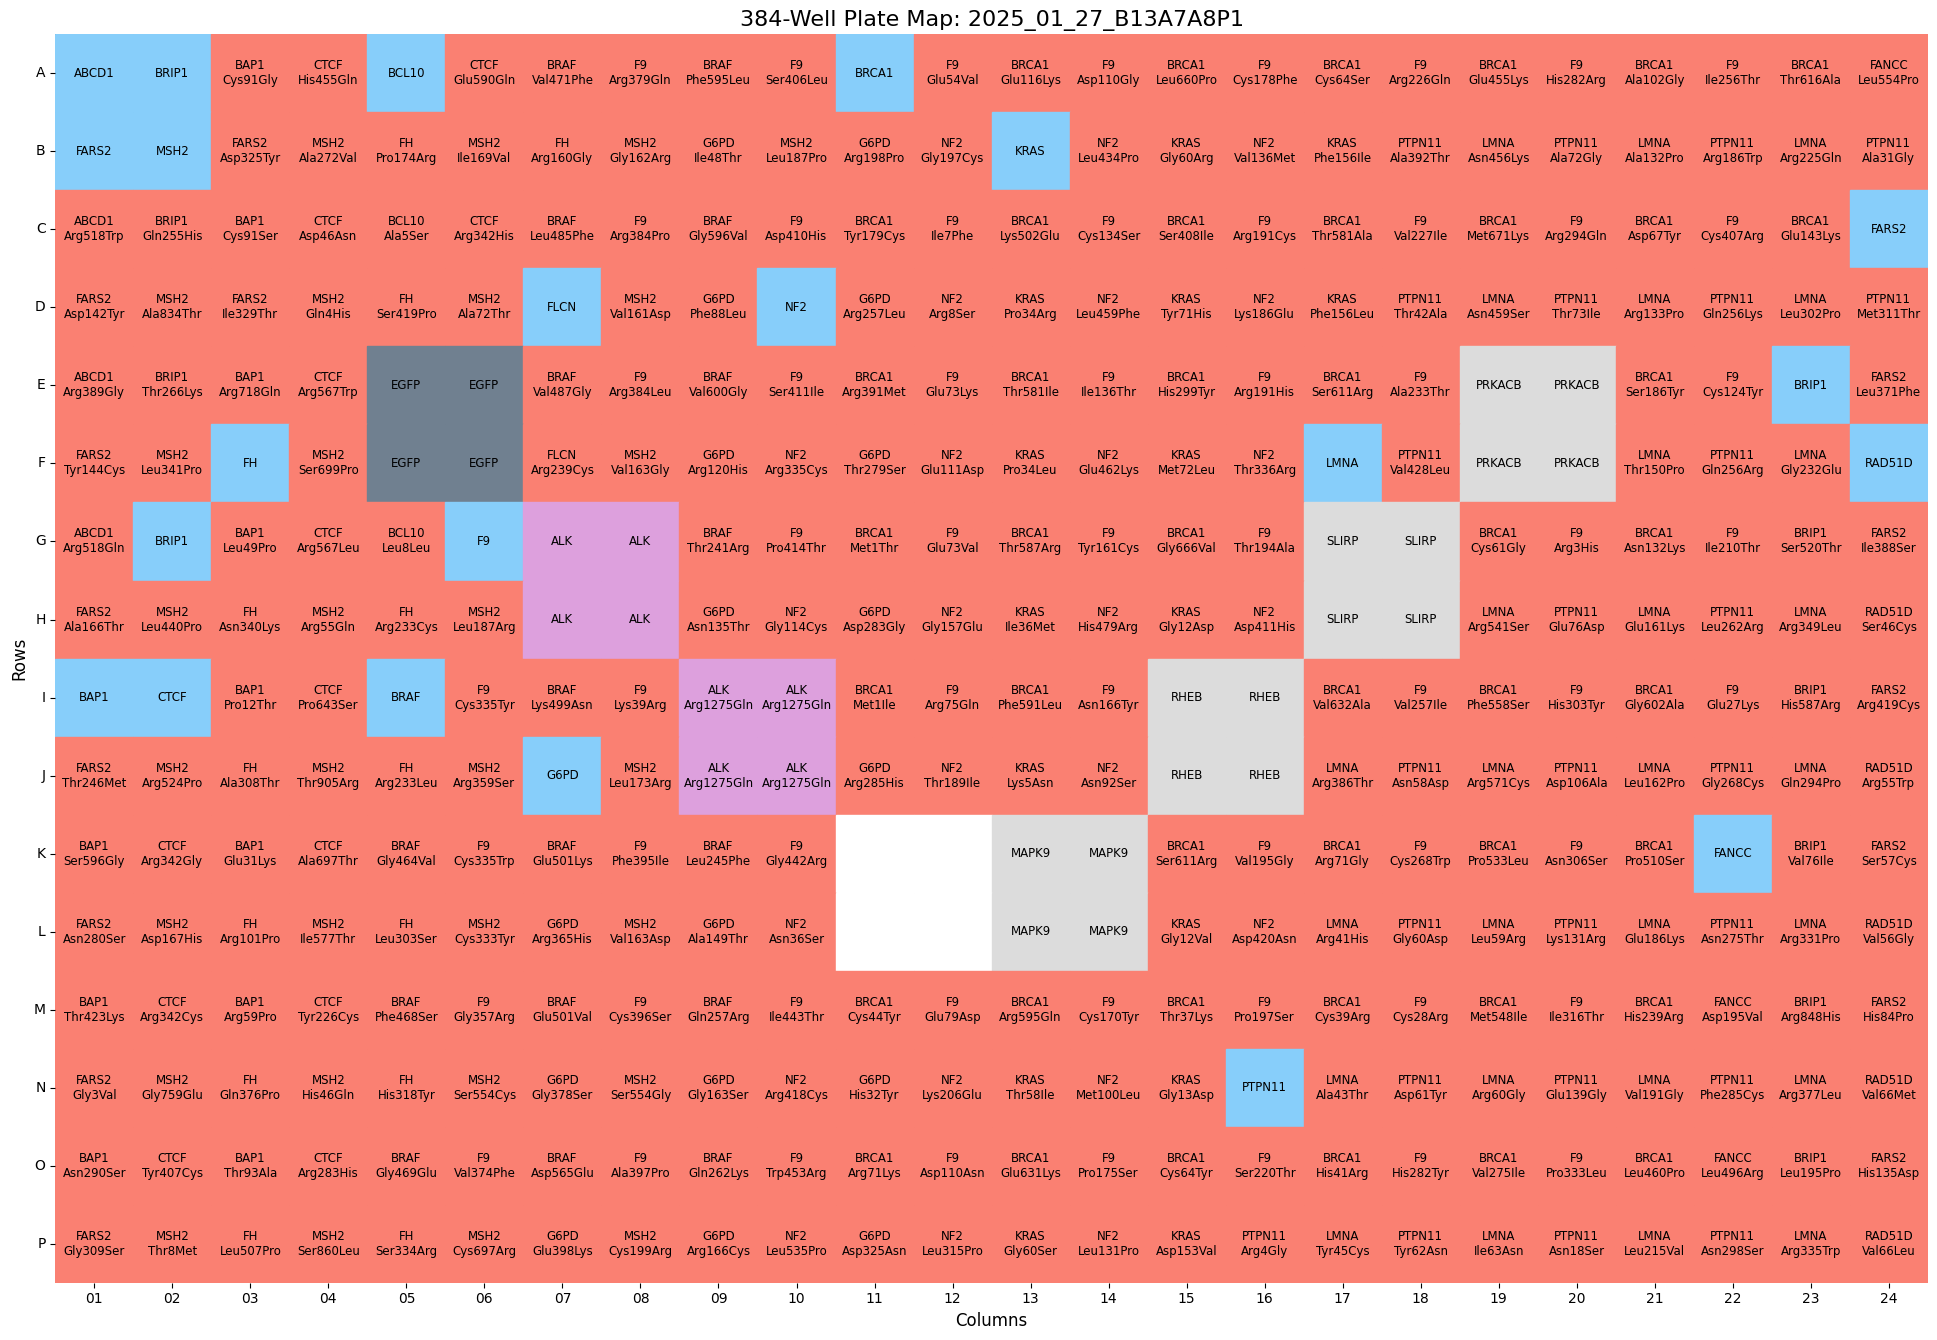

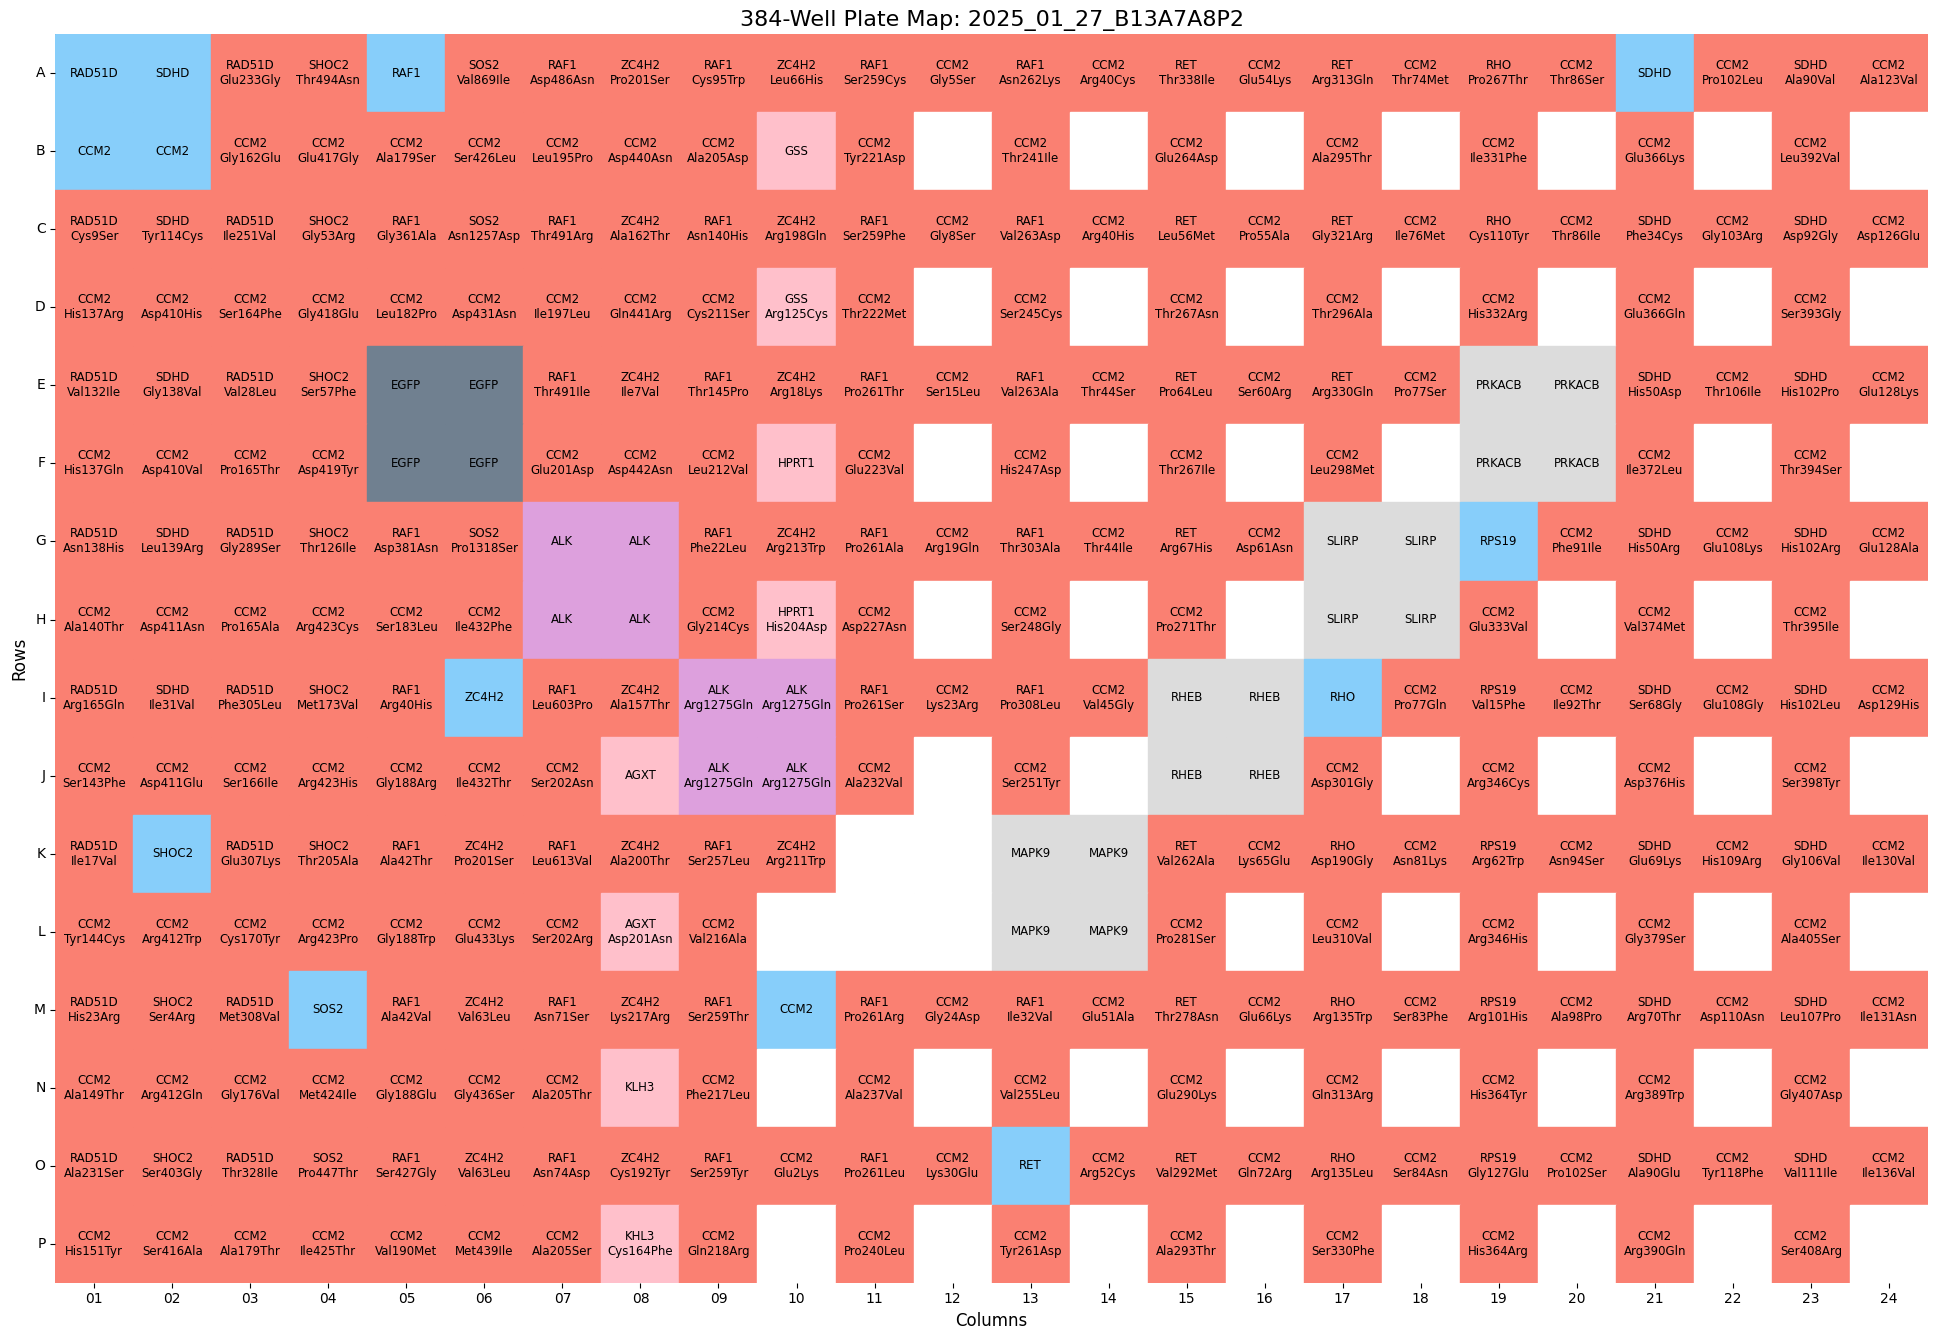

In [34]:
## clean up the meta file a little bit
## remove the unwanted '_' in the columns
meta_dat_b134_corrected = meta_dat_b134_corrected.with_columns(
    pl.when(pl.col("gene_allele").str.ends_with("_") & (pl.col("gene_allele") != "_"))  # Condition 2: Remove trailing "_"
      .then(pl.col("gene_allele").str.replace(r"_$", ""))
      .otherwise(pl.col("gene_allele"))
      .alias("gene_allele") # Remove trailing "_"
)
## remove unnecessary weired chars
meta_dat_b134_corrected = meta_dat_b134_corrected.with_columns(
    pl.col("symbol").str.replace_all(r"[^a-zA-Z0-9_]", ""),#.alias("symbol"), ## remove unnessary chars
    pl.col("gene_allele").str.replace_all(r"[^a-zA-Z0-9_]", ""),#.alias("gene_allele"), ## remove unnessary chars
)
## correct eGFP to EGFP
meta_dat_b134_corrected = meta_dat_b134_corrected.with_columns(
    pl.col("symbol").str.replace('eGFP', 'EGFP'),#.alias("symbol"),
    pl.col("gene_allele").str.replace('eGFP', 'EGFP')#.alias("gene_allele")
)

plate_grid = plot_platemap(
    meta_dat_b134_corrected.filter(pl.col("imaging_plate_R1")=="B13A7A8P1_R1").filter(
                ~pl.all_horizontal(pl.all().is_null())
            ).with_columns(pl.col("node_type").alias("control_type"),
                          pl.col("imaging_well").alias("well_position")), 
    "2025_01_27_B13A7A8P1")

plate_grid = plot_platemap(
    meta_dat_b134_corrected.filter(pl.col("imaging_plate_R1")=="B13A7A8P2_R1").filter(
                ~pl.all_horizontal(pl.all().is_null())
            ).with_columns(pl.col("node_type").alias("control_type"),
                          pl.col("imaging_well").alias("well_position")), 
    "2025_01_27_B13A7A8P2")

In [35]:
# meta_dat_b134_corrected.write_csv("../../output/meta_correct_batch13-14/2025_01_27_Batch_13/platemap/B13-14_metadata_update_cleaned.csv", separator=",")

### Old damaged platemaps

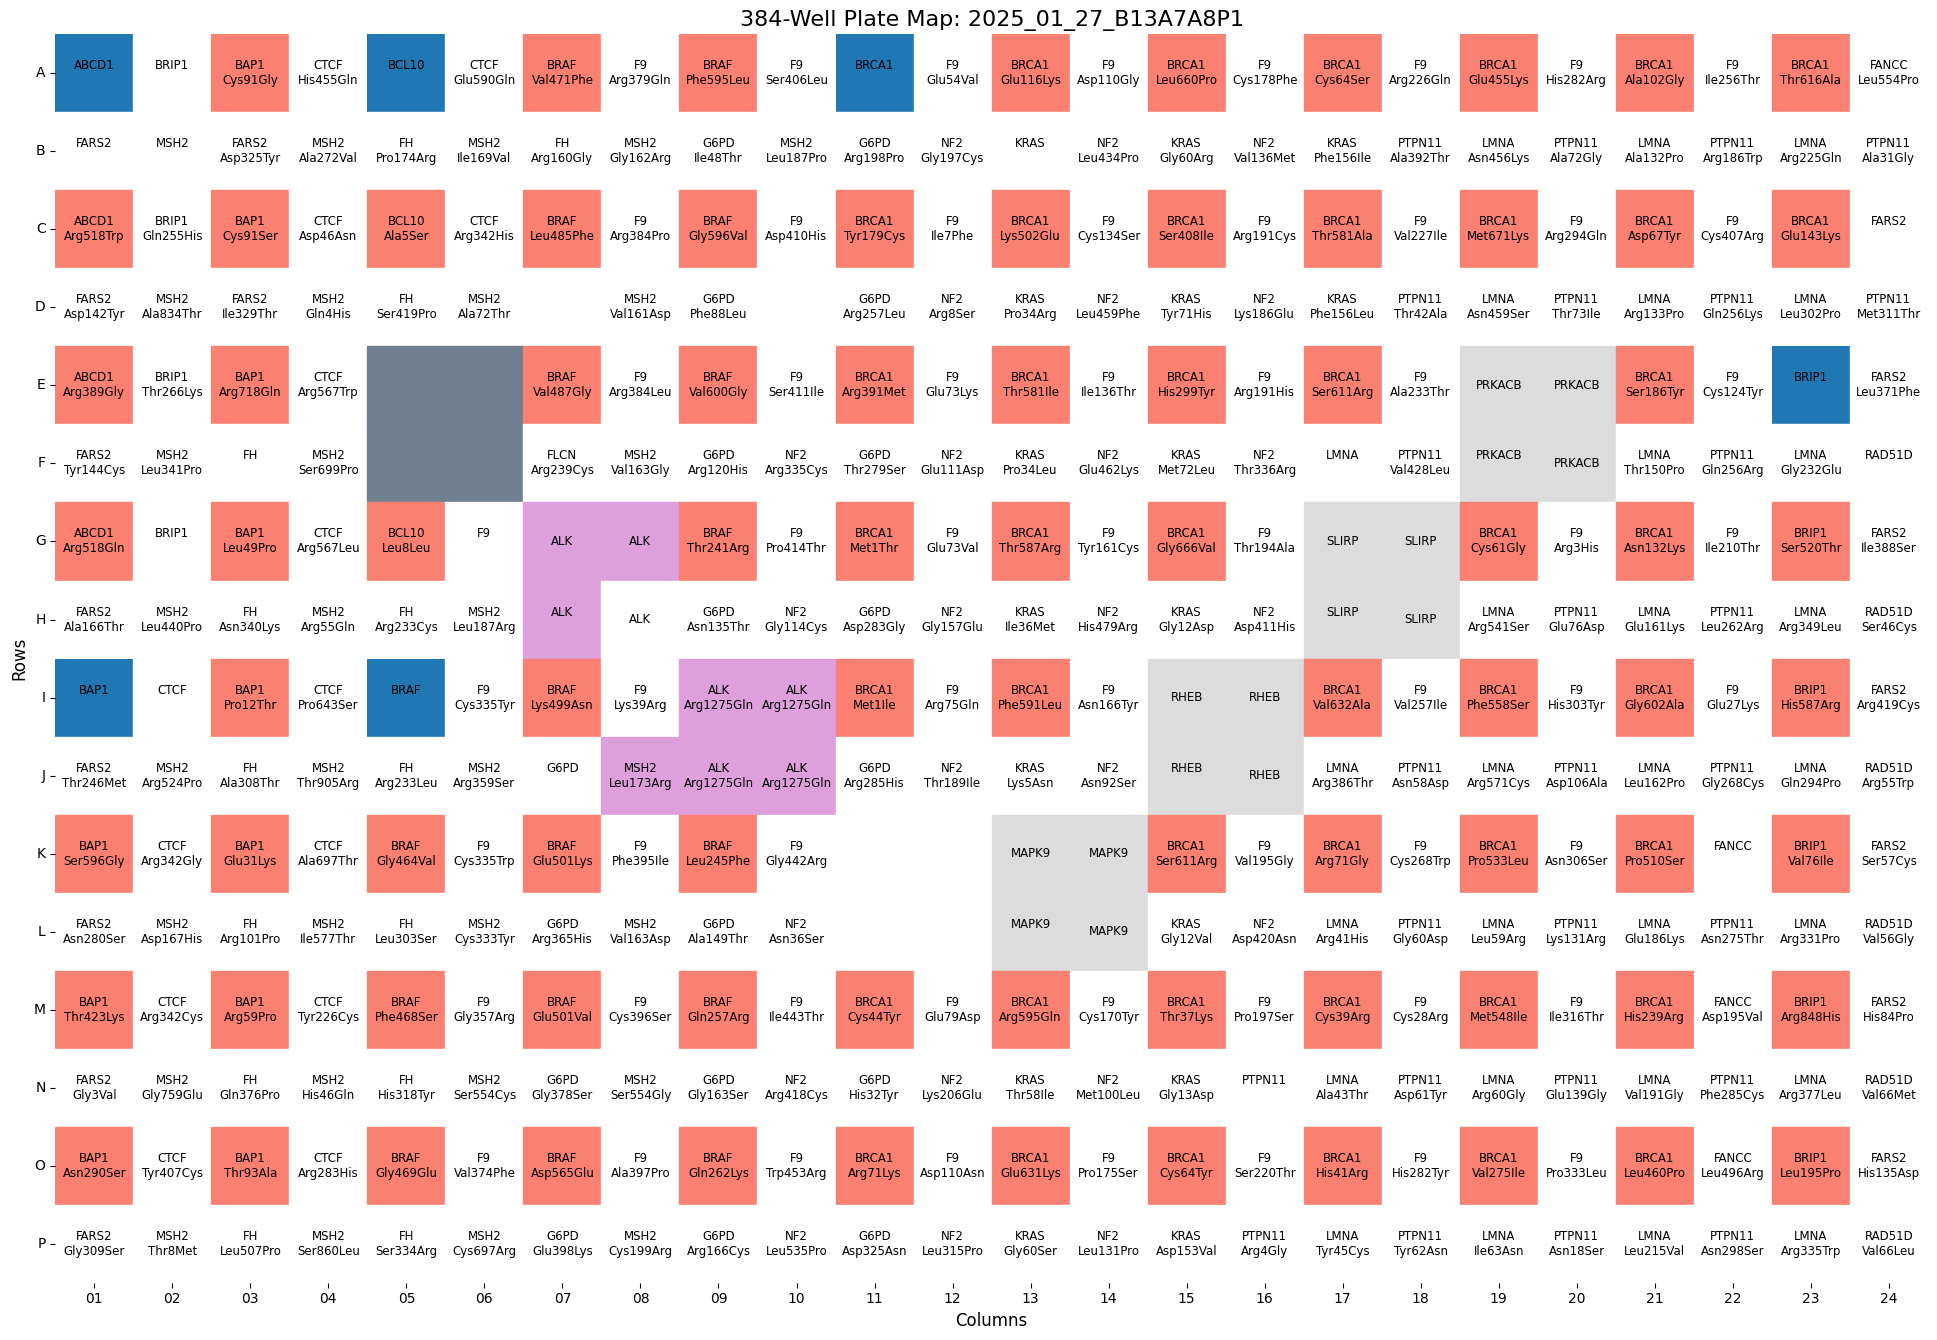

In [25]:
# batch_dir = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/inputs/metadata/platemaps/2025_01_27_Batch_13/platemap/"
# for plate_map_id in os.listdir(batch_dir):
plate_map_id = "2025_01_27_B13A7A8P1_T1.txt"
plate_map = pl.read_csv(Path(batch_dir_13) / Path(plate_map_id), separator='\t', has_header=True)
## Drop a row only if all values are null: 
## (DO NOT use drop_nulls() directly here as it drops all rows with a null in it)
plate_map = plate_map.filter(
                ~pl.all_horizontal(pl.all().is_null())
            ).with_columns(pl.col("node_type").alias("control_type"))
plate_grid = plot_platemap(plate_map, "2025_01_27_B13A7A8P1")

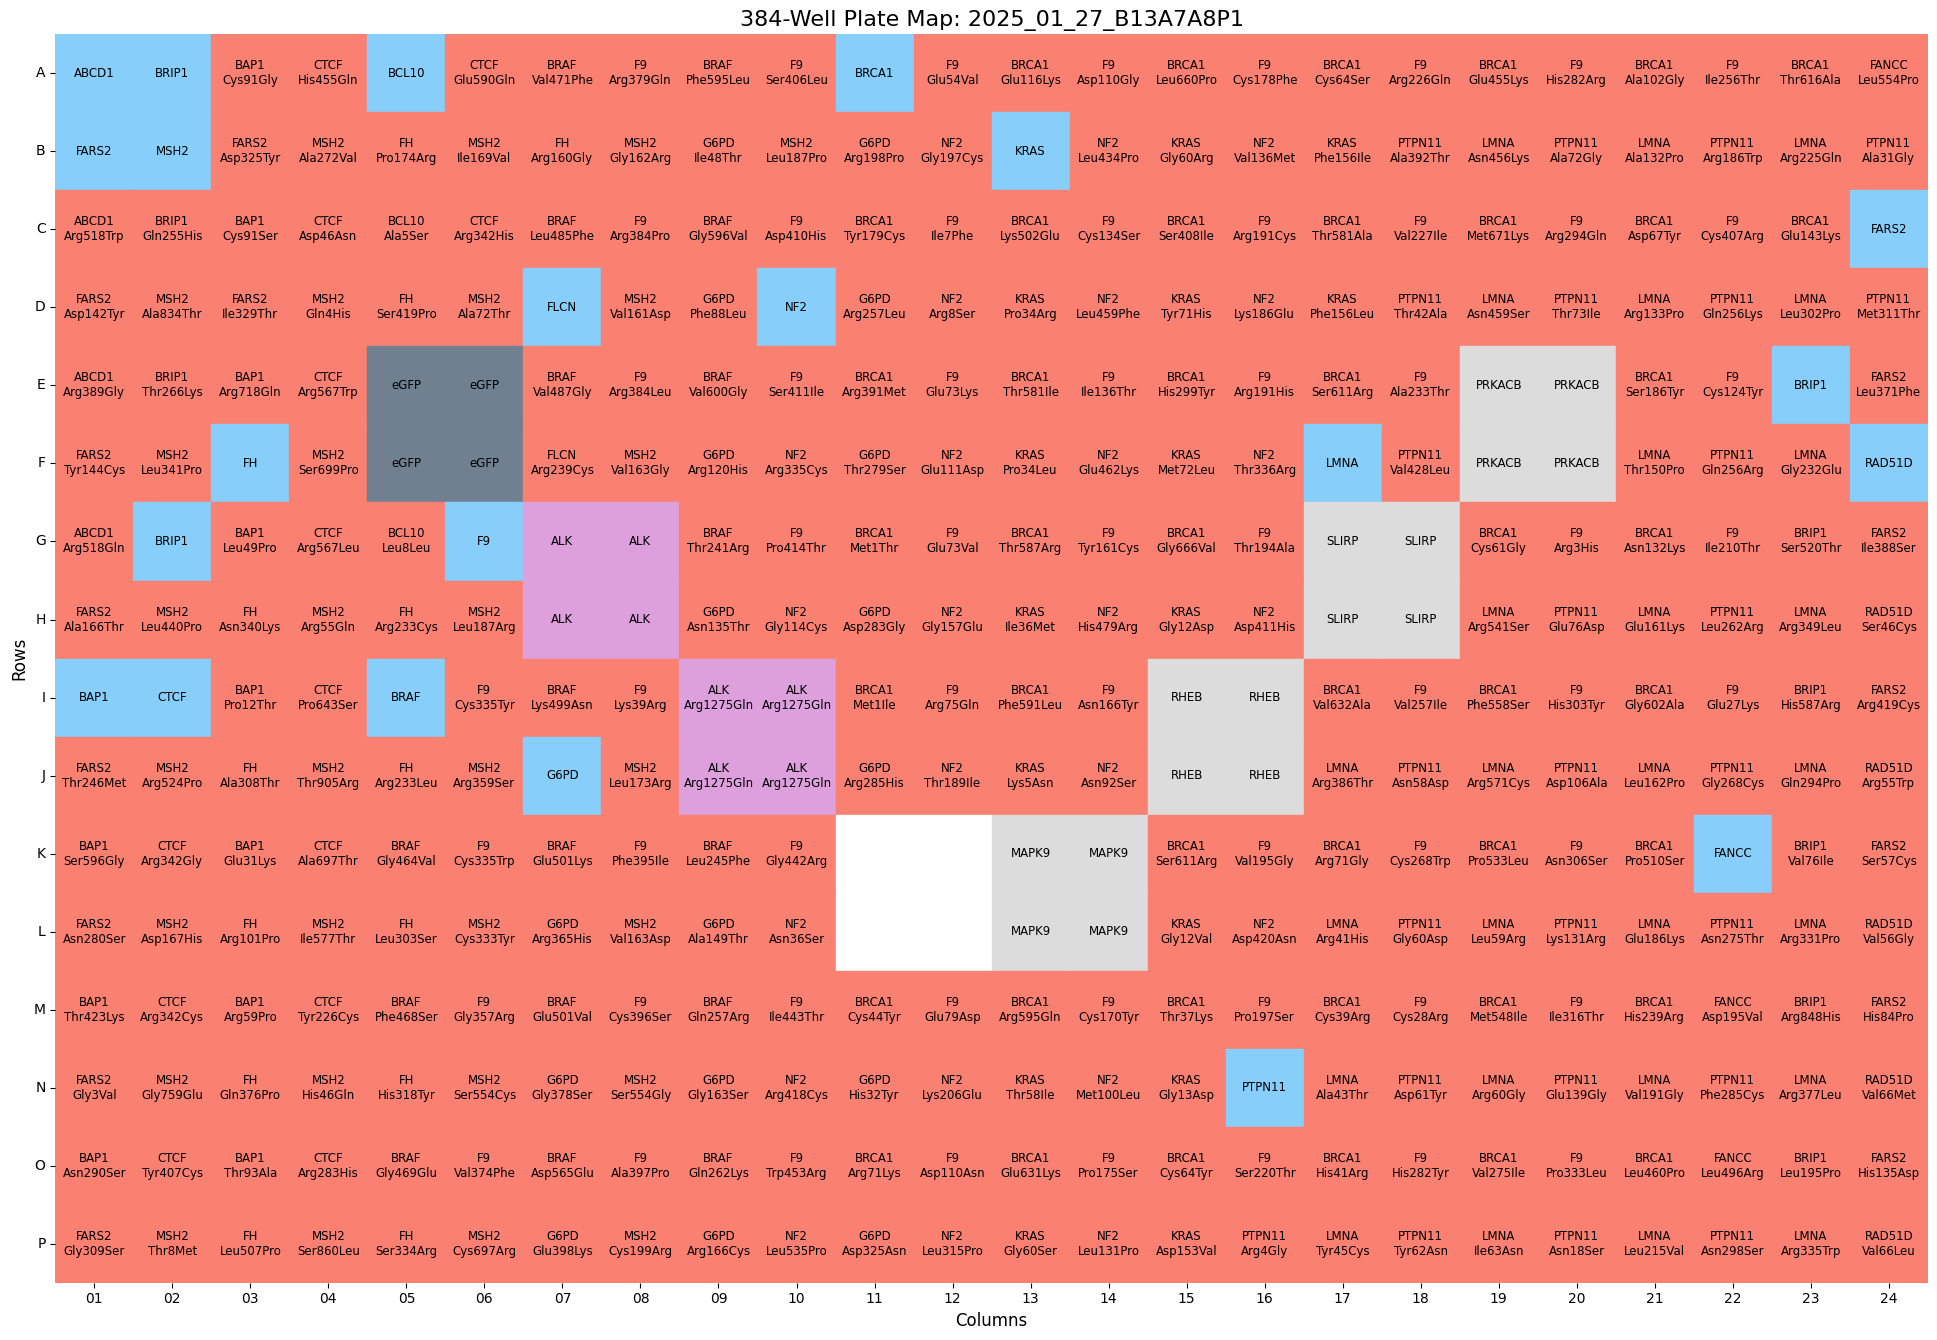

In [26]:
plate_map = plate_map.with_columns(
    # pl.col("symbol").alias("symbol_original"),
    # ## clean up the symbols first
    # pl.col("symbol").str.replace_all(r'[^a-zA-Z0-9]', '').alias("symbol"),
    # Condition 1: Keep "_" as is or fill the symbol if gene allele is missing by accident
    pl.when((pl.col("gene_allele")=="_")|(pl.col("gene_allele").is_null()&pl.col("symbol").is_not_null()))
        .then(pl.col("symbol"))
        .when(pl.col("gene_allele").str.ends_with("_") & (pl.col("gene_allele") != "_"))  # Condition 2: Remove trailing "_"
        .then(pl.col("gene_allele").str.replace(r"_$", ""))  # Remove trailing "_"
        .otherwise(pl.col("gene_allele"))  # Keep other values unchanged
        .alias("gene_allele"),  # Replace the original column,
    pl.when(pl.col("gene_allele") == "_")
        .then(pl.col("gene_allele"))
        .when(pl.col("gene_allele").str.contains("_"))
        .then(pl.col("gene_allele").str.extract(r"^(.*?)_", 1))
        .otherwise(pl.col("gene_allele"))
        .alias("symbol"),
    pl.when((pl.col("gene_allele").is_in(PC))) #(pl.col("node_type").is_null())
        .then(pl.lit("PC"))
        .when((pl.col("gene_allele").is_in(NC))) #(pl.col("node_type").is_null())
        .then(pl.lit("NC"))
        # .when((pl.col("gene_allele").is_in(cPC))) #(pl.col("node_type").is_null())
        # .then(pl.lit("cPC"))
        .when(pl.col("aa_change").is_not_null()) ## manually handle a special case
        .then(pl.lit("allele"))
        .when((pl.col("aa_change").is_null())&(pl.col("symbol").is_not_null())&(~pl.col("symbol").is_in(PC))&(~pl.col("symbol").is_in(NC))&(~pl.col("symbol").str.to_uppercase().is_in(TC))) ## (pl.col("node_type").is_null())&
        .then(pl.lit("disease_wt"))
        .when(pl.col("node_type").is_not_null())
        .then(pl.col("node_type"))
        .when((pl.col("symbol").str.to_uppercase().is_in(TC))) #(pl.col("node_type").is_null())
        .then(pl.lit("TC"))
        .alias("control_type")
    # pl.when(pl.col("gene_allele") == "_")
    #     .then(pl.lit("control"))
    #     .when(pl.col("gene_allele").str.contains("_"))
    #     .then(pl.lit("allele"))
    #     .otherwise(pl.lit("disease_wt"))
    #     .alias("control_type"),
)
plate_grid = plot_platemap(plate_map, "2025_01_27_B13A7A8P1")

In [27]:
# plate_grid.with_columns(pl.col("control_type").alias("node_type")).select(plate_map.columns).write_csv("../../output/meta_correct_batch13-14/2025_01_27_Batch_13/platemap/2025_01_27_B13A7A8P1_T1.txt", separator="\t")
# plate_grid.with_columns(pl.col("control_type").alias("node_type")).select(plate_map.columns).write_csv("../../output/meta_correct_batch13-14/2025_01_27_Batch_13/platemap/2025_01_27_B13A7A8P1_T1.txt", separator="\t")
# plate_grid.with_columns(pl.col("control_type").alias("node_type")).select(plate_map.columns).write_csv("../../output/meta_correct_batch13-14/2025_01_27_Batch_13/platemap/2025_01_27_B13A7A8P1_T1.txt", separator="\t")
# plate_grid.with_columns(pl.col("control_type").alias("node_type")).select(plate_map.columns).write_csv("../../output/meta_correct_batch13-14/2025_01_27_Batch_13/platemap/2025_01_27_B13A7A8P1_T1.txt", separator="\t")

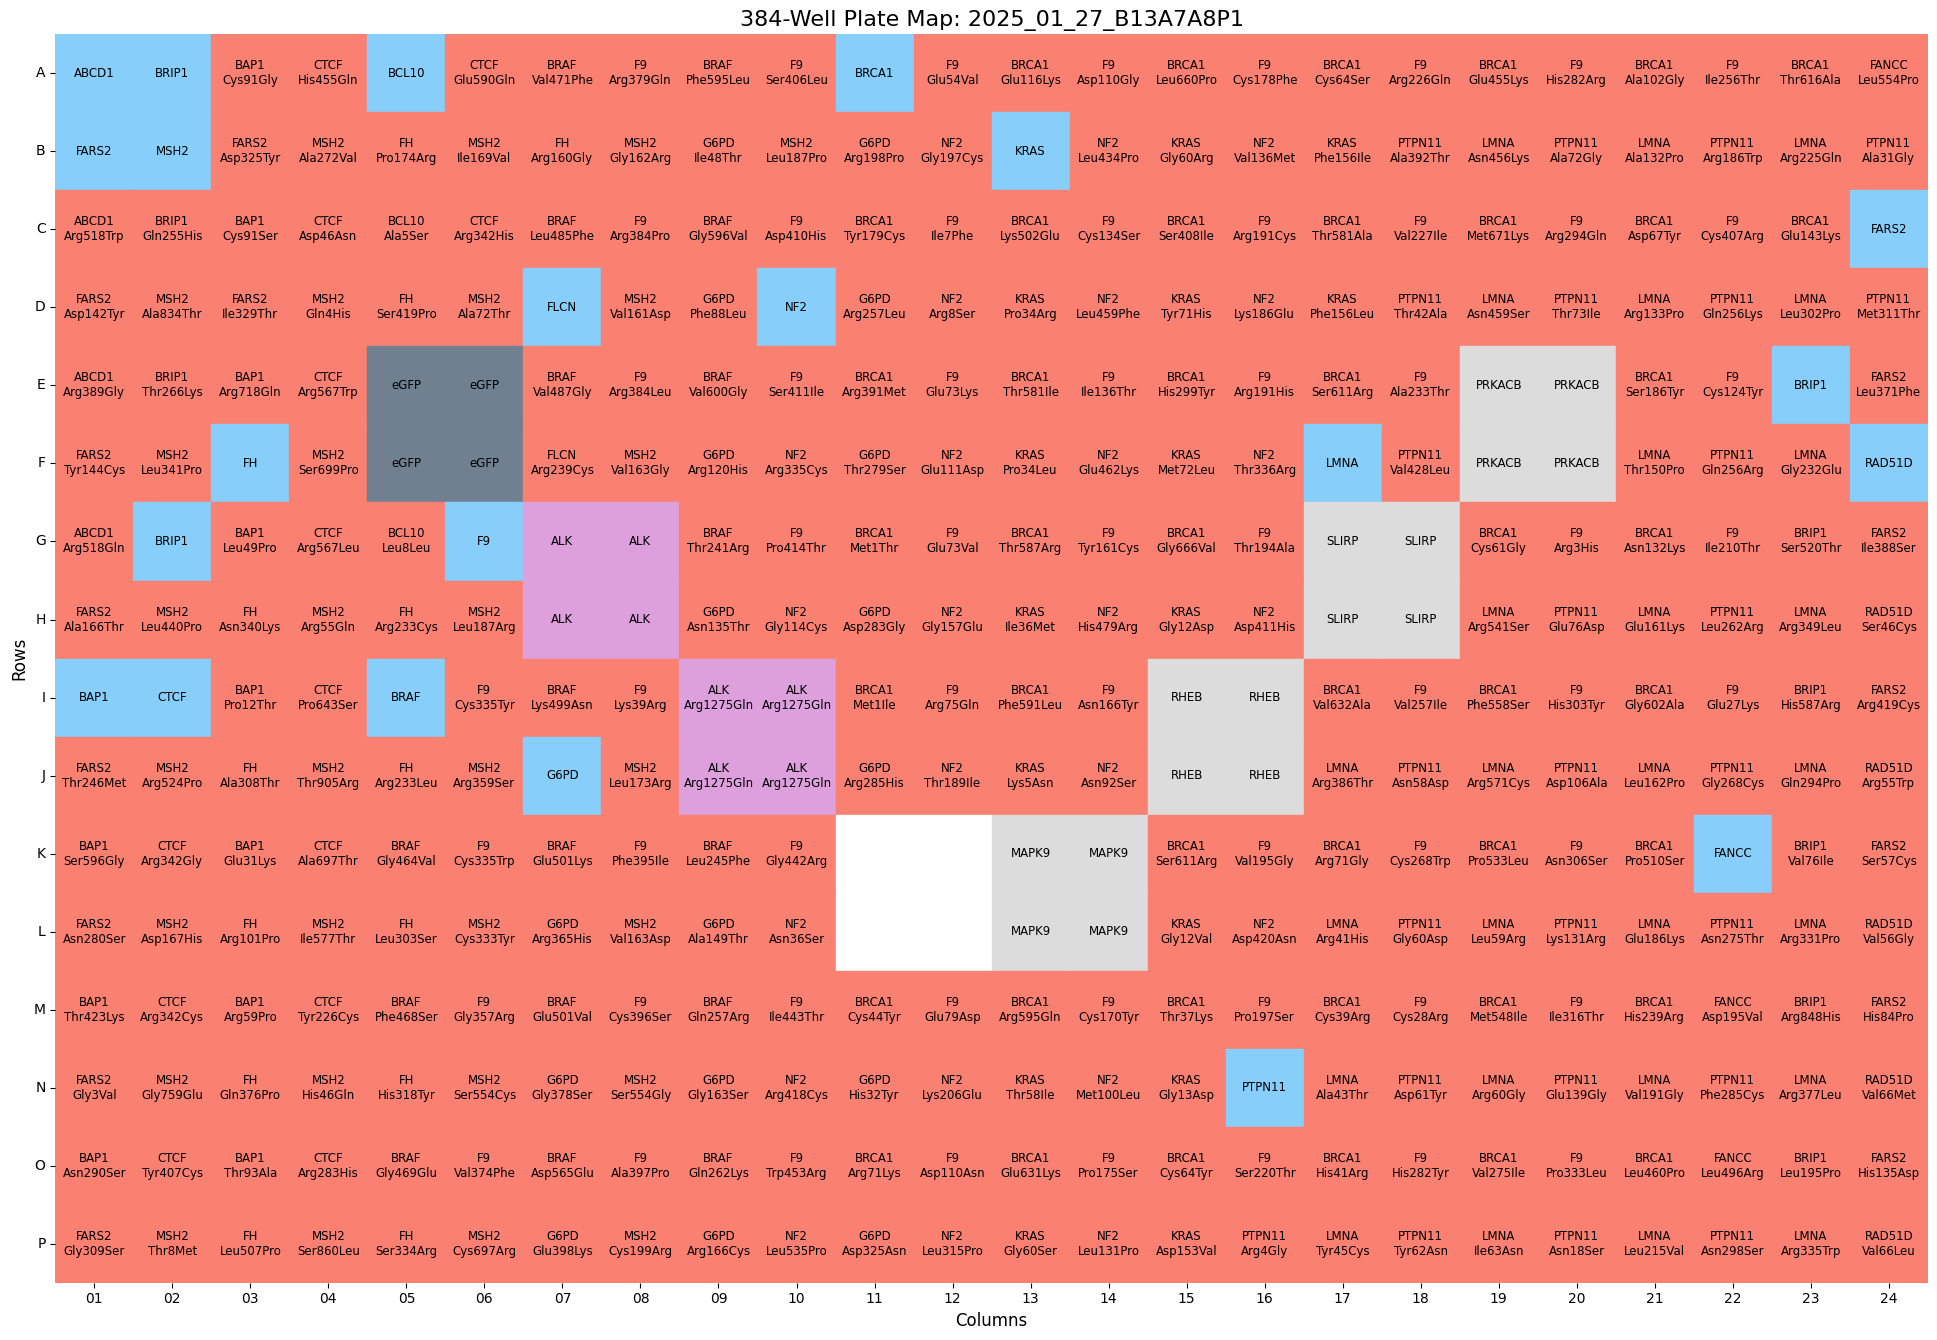

In [4]:
# plate_map.filter(pl.col("well_position")=="E19")
# plate_map.filter(pl.col("well_position")=="E19")
# plate_map.filter(pl.col("symbol")=="FLCN")
# plate_map.filter(pl.col("symbol").str.to_uppercase().is_in(TC))

batch_dir = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/7.analysis_runxi/output/meta_correct_batch13-14/2025_01_27_Batch_13/platemap/"
# for plate_map_id in os.listdir(batch_dir):
plate_map_id = "2025_01_27_B13A7A8P1_T1.txt"
plate_map = pl.read_csv(Path(batch_dir) / Path(plate_map_id), separator='\t', has_header=True)

## Drop a row only if all values are null: 
## (DO NOT use drop_nulls() directly here as it drops all rows with a null in it)
plate_map = plate_map.filter(
                ~pl.all_horizontal(pl.all().is_null())
            ).with_columns(pl.col("node_type").alias("control_type"))
plate_grid = plot_platemap(plate_map, "2025_01_27_B13A7A8P1")

### Second plate

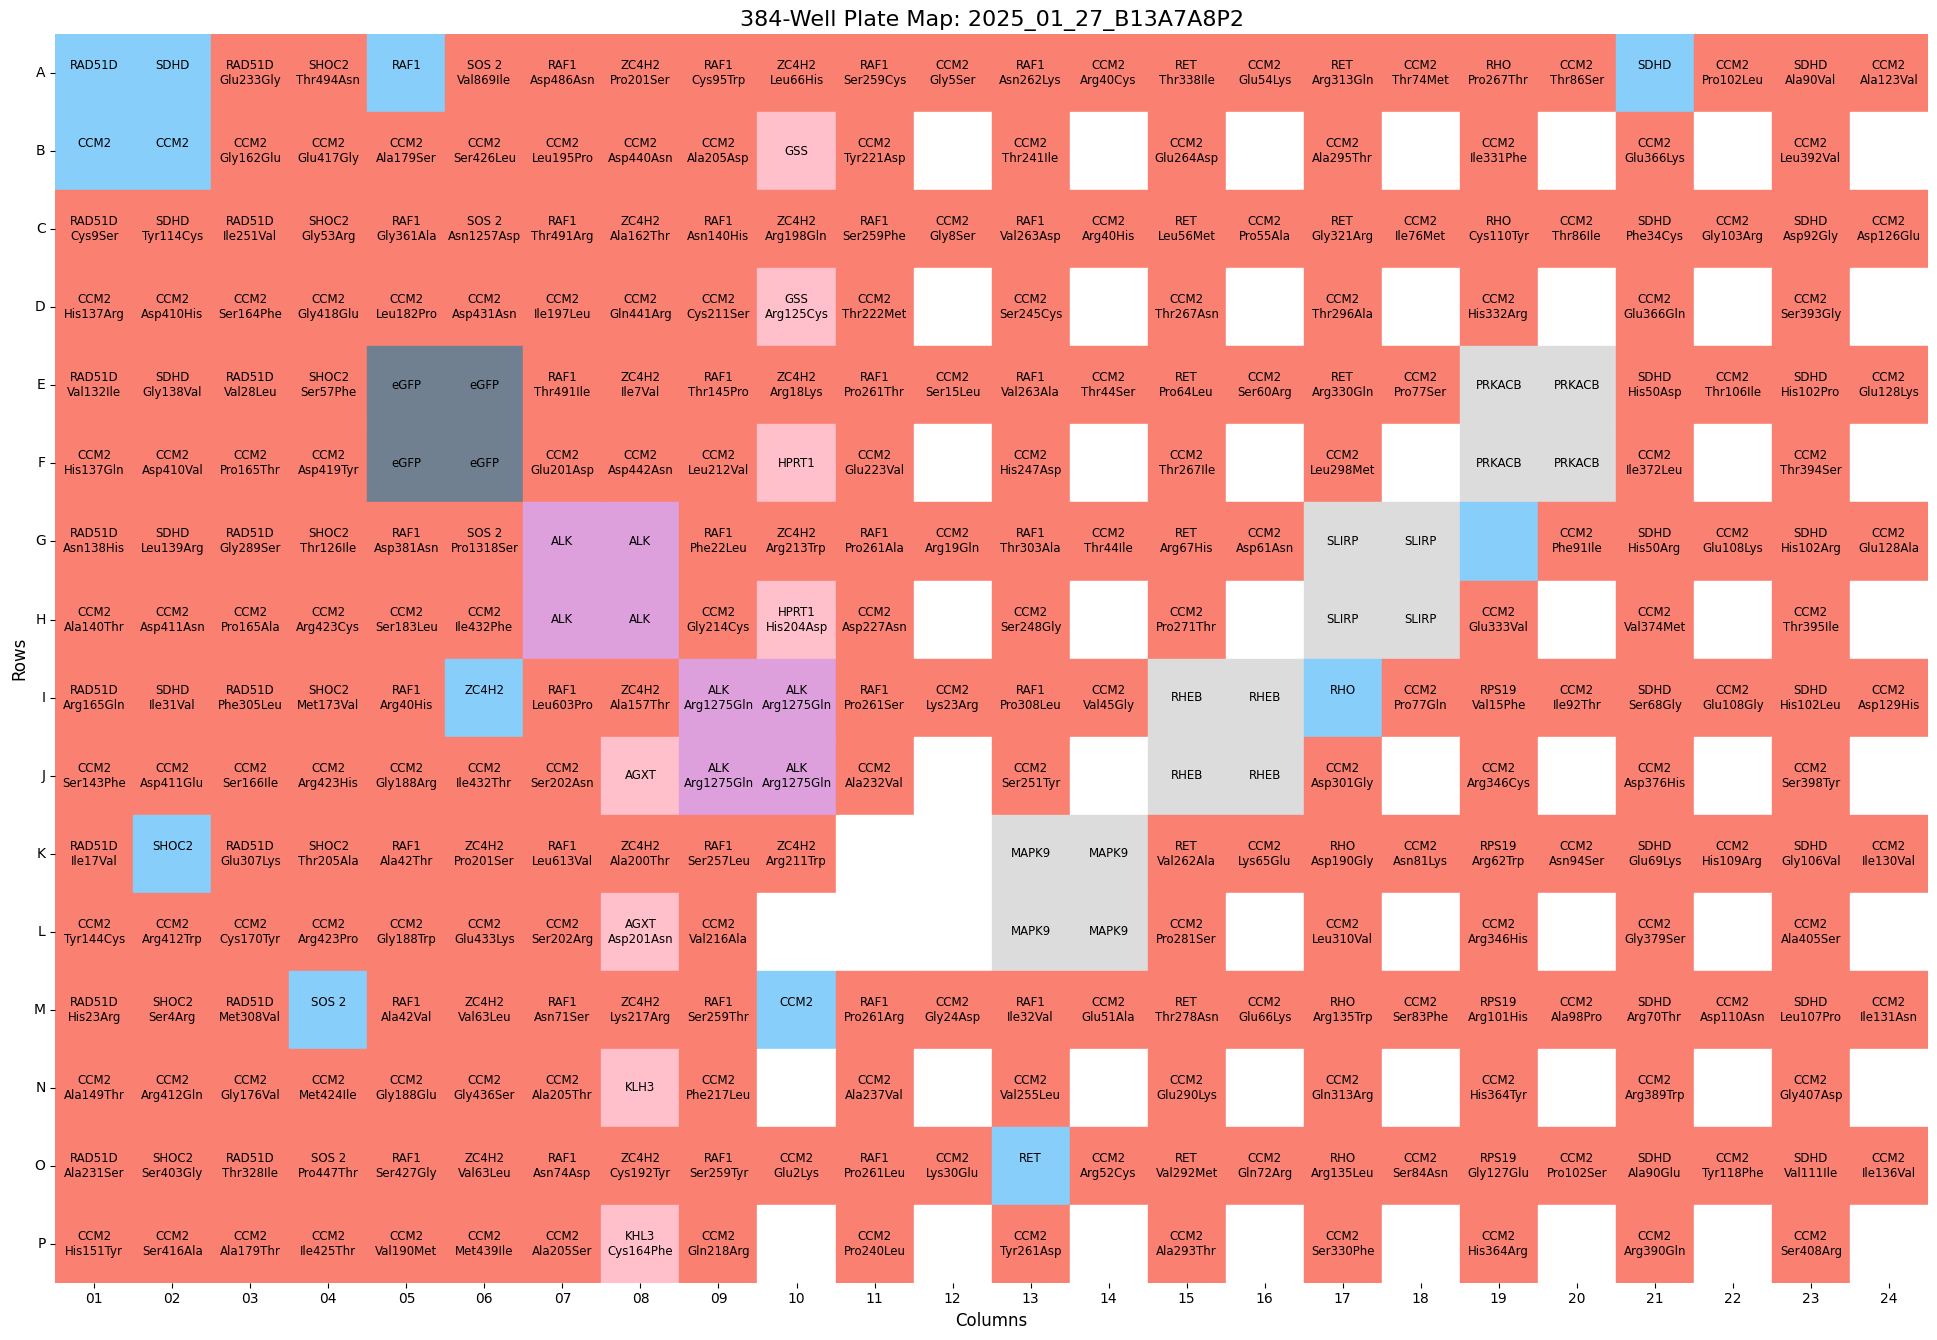

In [24]:
batch_dir = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/inputs/metadata/platemaps/2025_01_27_Batch_13/platemap/"

# for plate_map_id in os.listdir(batch_dir):
plate_map_id = "2025_01_27_B13A7A8P2_T1.txt"
plate_map = pl.read_csv(Path(batch_dir) / Path(plate_map_id), separator='\t', has_header=True)

## Drop a row only if all values are null: 
## (DO NOT use drop_nulls() directly here as it drops all rows with a null in it)
plate_map = plate_map.filter(
                ~pl.all_horizontal(pl.all().is_null())
            ).with_columns(pl.col("node_type").alias("control_type"))
plate_grid = plot_platemap(plate_map, "2025_01_27_B13A7A8P2")

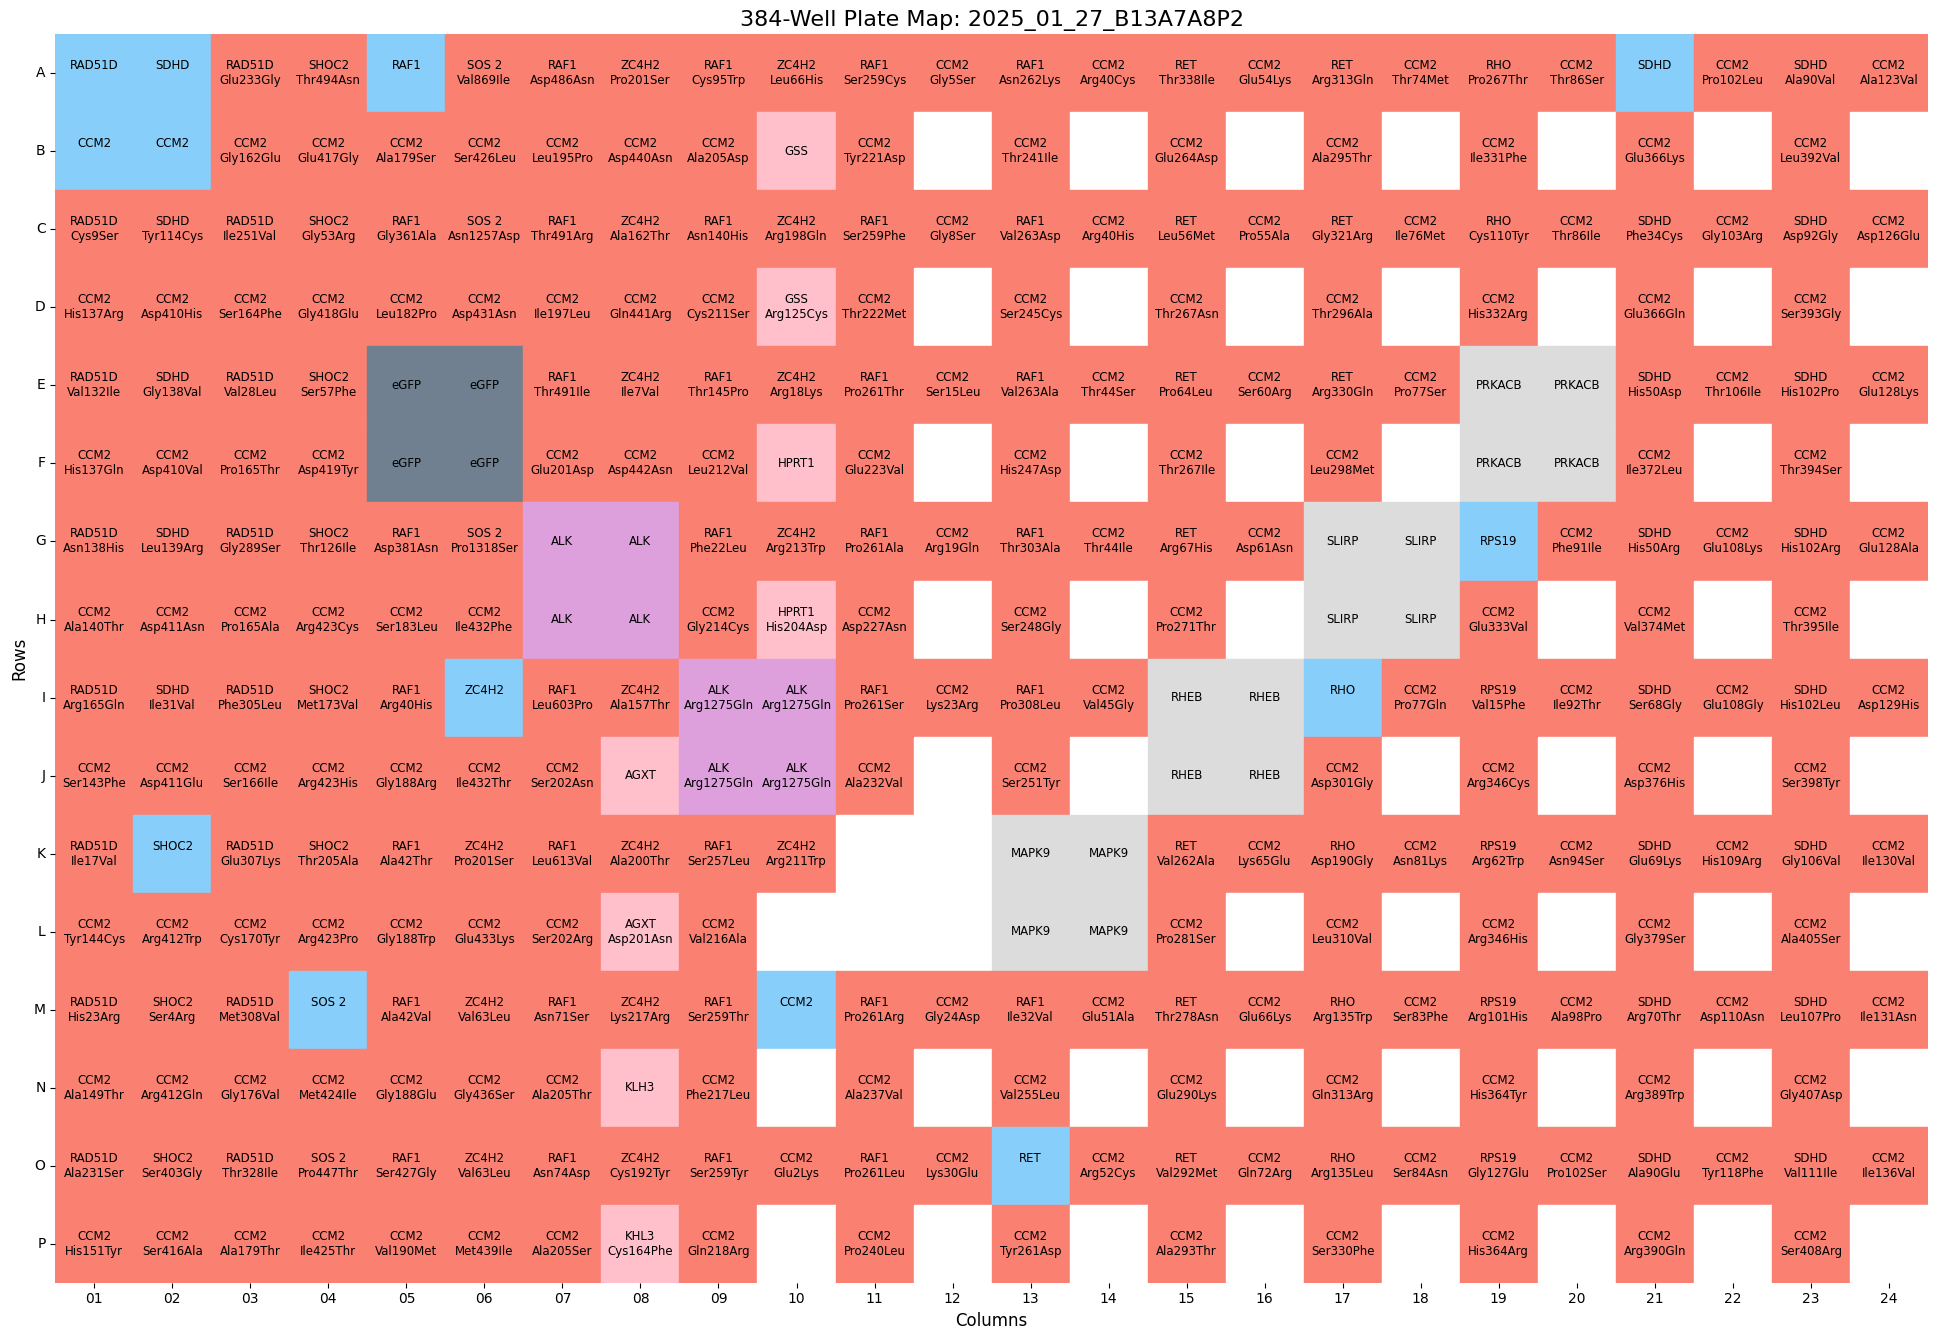

In [5]:
batch_dir = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/7.analysis_runxi/output/meta_correct_batch13-14/2025_01_27_Batch_13/platemap/"
# for plate_map_id in os.listdir(batch_dir):
plate_map_id = "2025_01_27_B13A7A8P2_T1.txt"
plate_map = pl.read_csv(Path(batch_dir) / Path(plate_map_id), separator='\t', has_header=True)

## Drop a row only if all values are null: 
## (DO NOT use drop_nulls() directly here as it drops all rows with a null in it)
plate_map = plate_map.filter(
                ~pl.all_horizontal(pl.all().is_null())
            ).with_columns(pl.col("node_type").alias("control_type"))
plate_grid = plot_platemap(plate_map, "2025_01_27_B13A7A8P2")

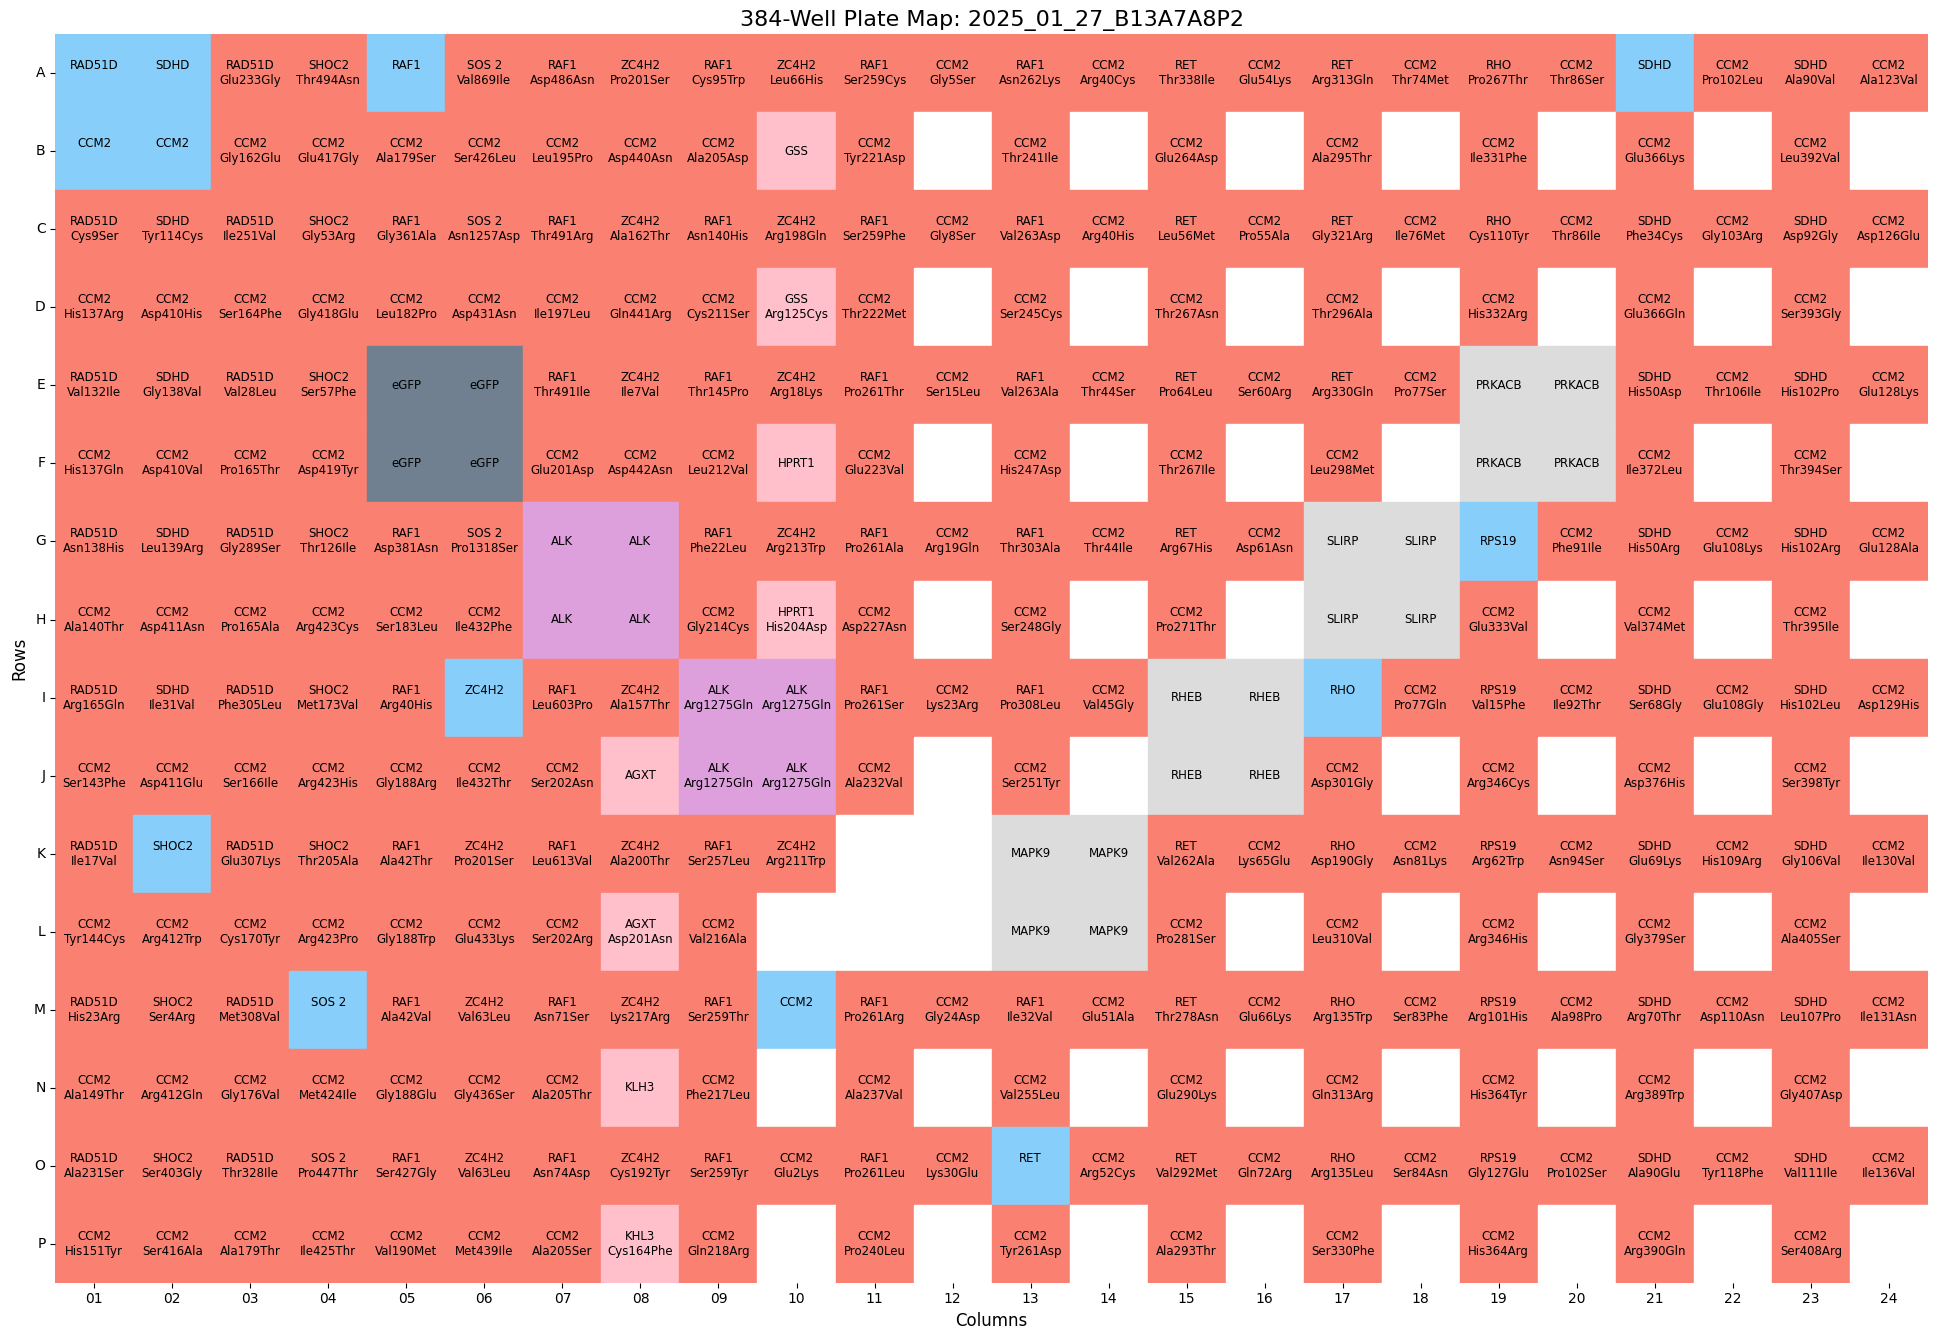

In [18]:
plate_map = plate_map.with_columns(
    # Condition 1: Keep "_" as is or fill the symbol if gene allele is missing by accident
    pl.when(pl.col("symbol").is_not_null()&pl.col("gene_allele").is_null())
        .then(pl.col("symbol"))
        .otherwise(pl.col("gene_allele"))
        .alias("gene_allele")
    # pl.when((pl.col("gene_allele")=="_")|(pl.col("gene_allele").is_null()&pl.col("symbol").is_not_null()))
    #     .then(pl.col("symbol"))
    #     .when(pl.col("gene_allele").str.ends_with("_") & (pl.col("gene_allele") != "_"))  # Condition 2: Remove trailing "_"
    #     .then(pl.col("gene_allele").str.replace(r"_$", ""))  # Remove trailing "_"
    #     .otherwise(pl.col("gene_allele"))  # Keep other values unchanged
    #     .alias("gene_allele"),  # Replace the original column,
    # pl.when(pl.col("gene_allele") == "_")
    #     .then(pl.col("gene_allele"))
    #     .when(pl.col("gene_allele").str.contains("_"))
    #     .then(pl.col("gene_allele").str.extract(r"^(.*?)_", 1))
    #     .otherwise(pl.col("gene_allele"))
    #     .alias("symbol"),
    # pl.when(pl.col("aa_change").is_not_null()) ## manually handle a special case
    #     .then(pl.lit("allele"))
    #     .when((pl.col("node_type").is_null())&(pl.col("aa_change").is_null())&(pl.col("symbol").is_not_null())&(~pl.col("symbol").is_in(PC)))
    #     .then(pl.lit("disease_wt"))
    #     .when((pl.col("node_type").is_null())&(pl.col("symbol").is_in(PC)))
    #     .then(pl.lit("PC"))
    #     # .when(pl.col("node_type").is_not_null())
    #     # .then(pl.col("node_type"))
    #     .alias("control_type")
)
plate_grid = plot_platemap(plate_map, "2025_01_27_B13A7A8P2")

In [21]:
# plate_grid.filter(pl.col("well_position")=="G19")

In [22]:
# plate_grid.with_columns(pl.col("control_type").alias("node_type")).select(plate_map.columns).write_csv("../../output/meta_correct_batch13-14/2025_01_27_Batch_13/platemap/2025_01_27_B13A7A8P2_T1.txt", separator="\t")

## Batch 9/10

### Confocal

Number of unique alleles: ['EGFP', 'F9_Glu27Lys', 'ALK_Arg1275Gln', 'PRKACB', 'LMNA', 'CTCF_Tyr226Cys', 'RPS19', 'RPS19_Val15Phe', 'CTCF_His455Gln', 'LMNA_Arg349Leu', 'G6PD_Glu398Lys', 'BCL10_Leu8Leu', 'F9_Glu73Val', 'G6PD', 'F9_Trp453Arg', 'FLCN_Arg239Cys', 'RPS19_Arg62Trp', 'LMNA_Arg331Pro', 'LMNA_Arg60Gly', 'FANCC_Asp195Val', 'LMNA_Glu186Lys', 'CTCF_Ala697Thr', 'F9_Pro333Leu', 'F9_Cys396Ser', '_', 'F9_Arg294Gln', 'RPS19_Arg101His', 'LMNA_Thr150Pro', 'F9_Ile256Thr', 'MRE11', 'MAPK9', 'F9_Cys170Tyr', 'F9_Gly357Arg', 'F9_Cys28Arg', 'CTCF_Arg342Cys', 'CTCF', 'CTCF_Asp46Asn', 'SLIRP', 'F9_Arg191His', 'F9_Cys268Trp', 'FANCC_Leu554Pro', 'CTCF_Glu590Gln', 'MRE11_Arg202Gly', 'LMNA_Tyr45Cys', 'LMNA_Ala132Pro', 'RPS19_Gly127Glu', 'CTCF_Arg342His', 'CTCF_Arg567Leu', 'CTCF_Arg342Gly', 'F9_Glu73Lys', 'CTCF_Tyr407Cys', 'F9_Arg384Pro', 'FANCC', 'F9_Arg226Gln', 'ALK', 'F9_Asp110Asn', 'LMNA_Arg541Ser', 'F9_Asp410His', 'LMNA_Gly232Glu', 'F9_His303Tyr', 'LMNA_Arg571Cys', 'F9_Asn306Ser', 'LMNA_Ala43Thr'

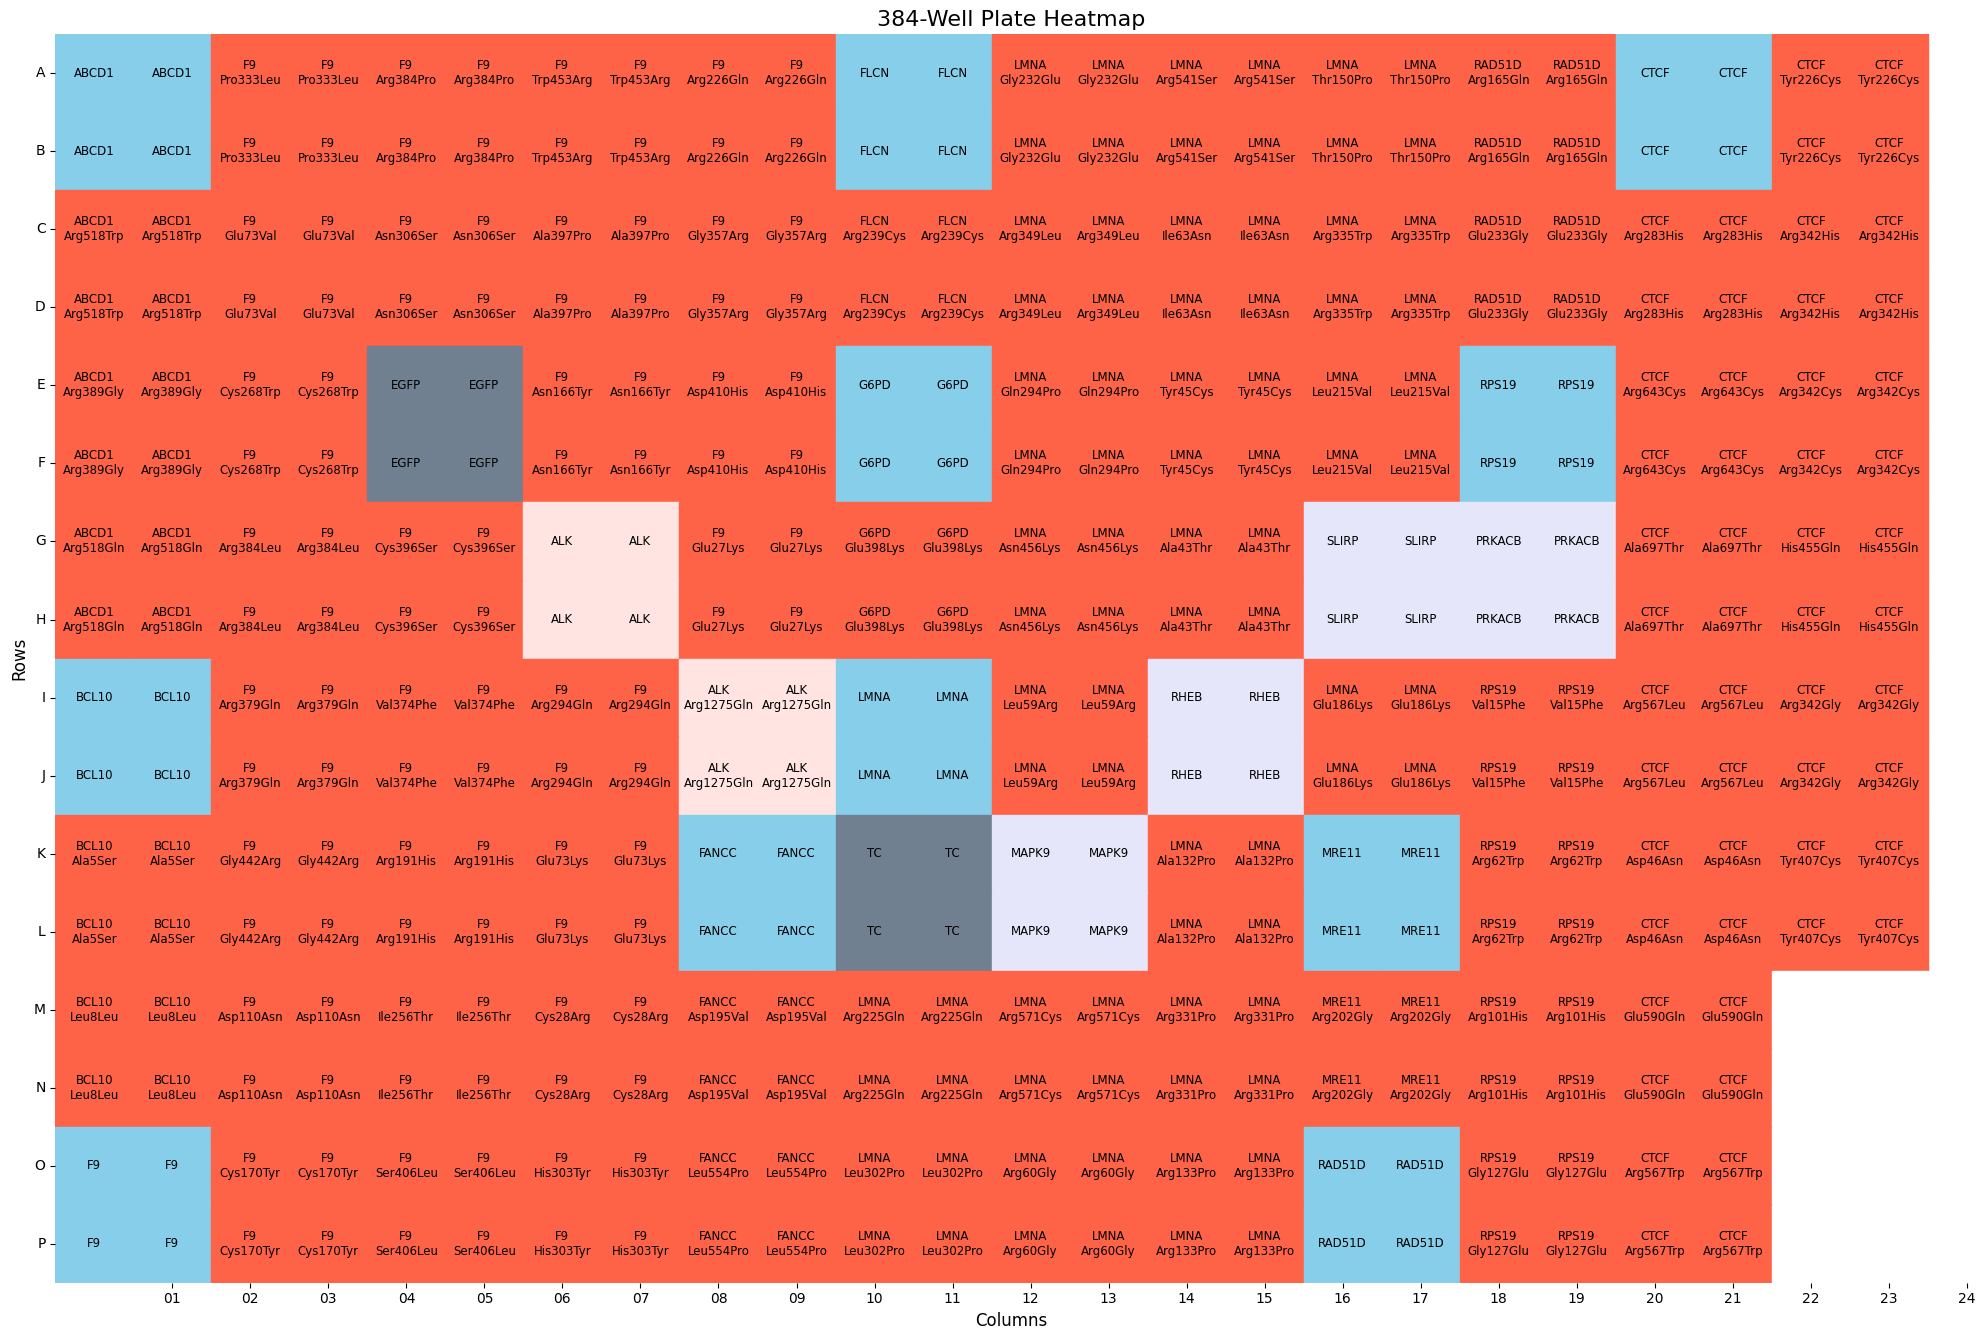

shape: (384, 32)
┌─────┬─────┬───────┬───────────┬───┬────────┬──────────────┬────────────┬───────────┐
│ row ┆ col ┆ value ┆ row_label ┆ … ┆ vector ┆ control_type ┆ color      ┆ label     │
│ --- ┆ --- ┆ ---   ┆ ---       ┆   ┆ ---    ┆ ---          ┆ ---        ┆ ---       │
│ u64 ┆ str ┆ str   ┆ str       ┆   ┆ i64    ┆ str          ┆ str        ┆ str       │
╞═════╪═════╪═══════╪═══════════╪═══╪════════╪══════════════╪════════════╪═══════════╡
│ 0   ┆ 01  ┆       ┆ A         ┆ … ┆ 594    ┆ disease_wt   ┆ disease_wt ┆ ABCD1     │
│ 1   ┆ 01  ┆       ┆ B         ┆ … ┆ 594    ┆ disease_wt   ┆ disease_wt ┆ ABCD1     │
│ 2   ┆ 01  ┆       ┆ C         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ ABCD1     │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Arg518Trp │
│ 3   ┆ 01  ┆       ┆ D         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ ABCD1     │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Arg518Trp │
│ 4   ┆ 01  ┆       ┆ E         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ ABCD1     │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Arg389Gly │
│ …   ┆ …   ┆ …     ┆ …         ┆ … ┆ …      ┆ …            ┆ …          ┆ …         │
│ 11  ┆ 24  ┆       ┆ L         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ CTCF      │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Tyr407Cys │
│ 12  ┆ 24  ┆       ┆ M         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 13  ┆ 24  ┆       ┆ N         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 14  ┆ 24  ┆       ┆ O         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 15  ┆ 24  ┆       ┆ P         ┆ … ┆ null   ┆ null         ┆            ┆           │
└─────┴─────┴───────┴───────────┴───┴────────┴──────────────┴────────────┴───────────┘

In [36]:
batch9_platemap_confo = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/inputs/metadata/platemaps/2024_10_28_Batch_9_confocal/platemap"
plate_map_id = "B9A6R1_P01.txt"
plate_map = pl.read_csv(Path(batch9_platemap_confo) / Path(plate_map_id), separator='\t', has_header=True)

## Drop a row only if all values are null: 
## (DO NOT use drop_nulls() directly here as it drops all rows with a null in it)
plate_map = plate_map.filter(~pl.all_horizontal(pl.all().is_null()))
# print(plate_map.shape

column_name = "gene_allele"
plate_map = plate_map.with_columns(
    pl.when(pl.col("gene_allele") == "_")  # Condition 1: Keep "_" as is
        .then(pl.col("gene_allele"))
        .when(pl.col("gene_allele").str.ends_with("_") & (pl.col("gene_allele") != "_"))  # Condition 2: Remove trailing "_"
        .then(pl.col("gene_allele").str.replace(r"_$", ""))  # Remove trailing "_"
        .otherwise(pl.col("gene_allele"))  # Keep other values unchanged
        .alias("gene_allele"),  # Replace the original column,
    pl.when(pl.col("gene_allele") == "_")
        .then(pl.col("gene_allele"))
        .when(pl.col("gene_allele").str.contains("_"))
        .then(pl.col("gene_allele").str.extract(r"^(.*?)_", 1))
        .otherwise(pl.col("gene_allele"))
        .alias("symbol"),
    pl.col("node_type").alias("control_type")
    # pl.when(pl.col("gene_allele") == "_")
    #     .then(pl.lit("control"))
    #     .when(pl.col("gene_allele").str.contains("_"))
    #     .then(pl.lit("allele"))
    #     .otherwise(pl.lit("disease_wt"))
    #     .alias("control_type"),
)

# print(plate_map.select(pl.col(column_name).unique()))
# print(plate_map.select(pl.col("gene_allele").unique()))
# # print(plate_map.select(pl.col("symbol").unique()))
plot_platemap(plate_map)

(236, 24)
Number of unique alleles: ['NF2_Lys206Glu', 'NF2_Met29Ile', 'ZC4H2_Arg211Trp', 'ALK', 'NF2_Ser489Gly', 'ZC4H2_Arg198Gln', '_', 'NF2_Asn220Tyr', 'ZC4H2_Lys217Arg', 'NF2_Asn92Ser', 'NF2_Met100Leu', 'ZC4H2_IIe7Val', 'NF2_Leu459Phe', 'NF2_Arg471Gly', 'ZC4H2_Ala200Thr', 'ZC4H2_Arg67Gln', 'NF2_Val136Met', 'NF2_Asp420Asn', 'NF2_Leu434Pro', 'NF2_Leu535Pro', 'EGFP', 'NF2_Leu315Pro', 'NF2_Thr336Arg', 'NF2_Glu111Asp', 'ZC4H2_Ala157Thr', 'NF2_Pro410Leu', 'ZC4H2_Val63Leu', 'NF2_Glu462Lys', 'ZC4H2_Leu66His', 'ALK_Arg1275Gln', 'NF2_Glu344Ala', None, 'NF2_Gly157Glu', 'NF2_Arg335Cys', 'NF2_Leu58Pro', 'NF2_Asp411His', 'NF2_Arg418Cys', 'NF2_Lys186Glu', 'ZC4H2_Ala162Thr', 'NF2_Leu277Pro', 'NF2_Pro19Arg', 'ZC4H2_Cys192Tyr', 'NF2_Leu131Pro', 'NF2_Gln64Pro', 'NF2_Arg8Ser', 'ZC4H2', 'ZC4H2_Pro201Ser', 'NF2_Thr189Ile', 'NF2_Asn36Ser', 'NF2_Leu375Arg', 'MAPK9', 'NF2', 'ZC4H2_Arg18Lys', 'NF2_His479Arg', 'ZC4H2_Arg213Trp']


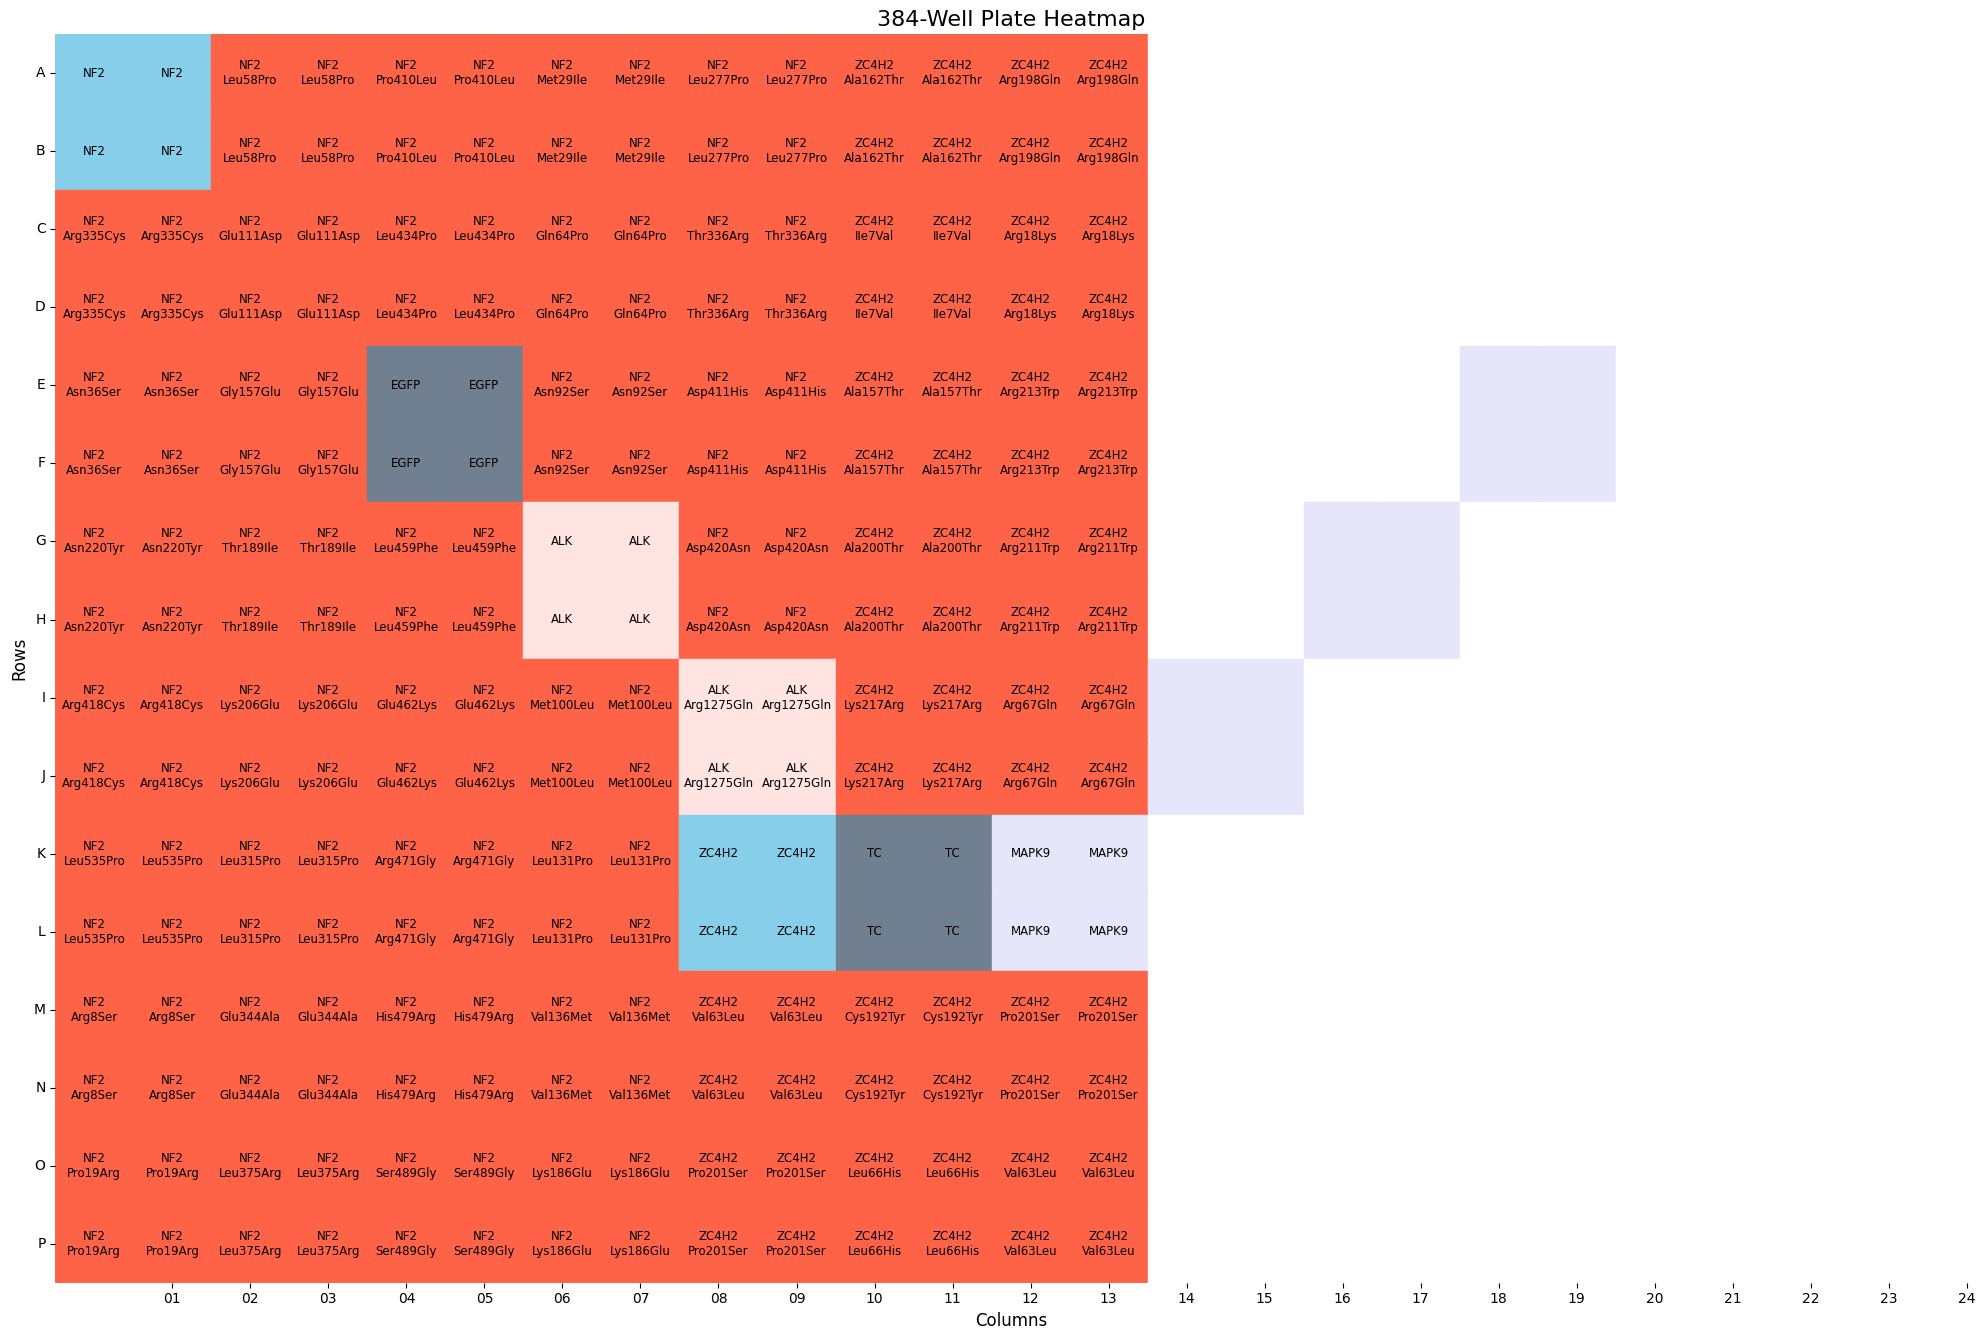

shape: (384, 32)
┌─────┬─────┬───────┬───────────┬───┬────────┬──────────────┬────────────┬───────────┐
│ row ┆ col ┆ value ┆ row_label ┆ … ┆ vector ┆ control_type ┆ color      ┆ label     │
│ --- ┆ --- ┆ ---   ┆ ---       ┆   ┆ ---    ┆ ---          ┆ ---        ┆ ---       │
│ u64 ┆ str ┆ str   ┆ str       ┆   ┆ i64    ┆ str          ┆ str        ┆ str       │
╞═════╪═════╪═══════╪═══════════╪═══╪════════╪══════════════╪════════════╪═══════════╡
│ 0   ┆ 01  ┆       ┆ A         ┆ … ┆ 594    ┆ disease_wt   ┆ disease_wt ┆ NF2       │
│ 1   ┆ 01  ┆       ┆ B         ┆ … ┆ 594    ┆ disease_wt   ┆ disease_wt ┆ NF2       │
│ 2   ┆ 01  ┆       ┆ C         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ NF2       │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Arg335Cys │
│ 3   ┆ 01  ┆       ┆ D         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ NF2       │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Arg335Cys │
│ 4   ┆ 01  ┆       ┆ E         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ NF2       │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Asn36Ser  │
│ …   ┆ …   ┆ …     ┆ …         ┆ … ┆ …      ┆ …            ┆ …          ┆ …         │
│ 11  ┆ 24  ┆       ┆ L         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 12  ┆ 24  ┆       ┆ M         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 13  ┆ 24  ┆       ┆ N         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 14  ┆ 24  ┆       ┆ O         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 15  ┆ 24  ┆       ┆ P         ┆ … ┆ null   ┆ null         ┆            ┆           │
└─────┴─────┴───────┴───────────┴───┴────────┴──────────────┴────────────┴───────────┘

In [37]:
batch9_platemap_confo = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/inputs/metadata/platemaps/2024_10_28_Batch_9_confocal/platemap"
plate_map_id2 = "B9A6R1_P02.txt"
plate_map_2 = pl.read_csv(Path(batch9_platemap_confo) / Path(plate_map_id2), separator='\t', has_header=True)
## Drop a row only if all values are null: 
## (DO NOT use drop_nulls() directly here as it drops all rows with a null in it)
plate_map_2 = plate_map_2.filter(~pl.all_horizontal(pl.all().is_null()))
print(plate_map_2.shape)
plate_map_2 = plate_map_2.with_columns(
    pl.when(pl.col("gene_allele") == "_")  # Condition 1: Keep "_" as is
        .then(pl.col("gene_allele"))
        .when(pl.col("gene_allele").str.ends_with("_") & (pl.col("gene_allele") != "_"))  # Condition 2: Remove trailing "_"
        .then(pl.col("gene_allele").str.replace(r"_$", ""))  # Remove trailing "_"
        .otherwise(pl.col("gene_allele"))  # Keep other values unchanged
        .alias("gene_allele"),  # Replace the original column,
    pl.when(pl.col("gene_allele") == "_")
        .then(pl.col("gene_allele"))
        .when(pl.col("gene_allele").str.contains("_"))
        .then(pl.col("gene_allele").str.extract(r"^(.*?)_", 1))
        .otherwise(pl.col("gene_allele"))
        .alias("symbol"),
    pl.col("node_type").alias("control_type")
)
plot_platemap(plate_map_2)

(376, 24)
Number of unique alleles: ['F9_Asp410His', 'RPS19_Gly127Glu', 'F9_Arg379Gln', 'F9_Arg384Pro', 'PRKACB', 'CTCF_Arg342Gly', 'F9_Cys28Arg', 'FLCN', 'F9_Arg384Leu', 'LMNA_Arg349Leu', 'RAD51D_Arg165Gln', 'G6PD_Glu398Lys', 'BCL10', 'F9_Arg191His', 'CTCF_Tyr407Cys', 'LMNA_Arg331Pro', 'F9_Val374Phe', 'LMNA_Arg133Pro', 'MRE11', 'CTCF_Tyr226Cys', 'ABCD1_Arg389Gly', 'ABCD1_Arg518Gln', 'F9_Asp110Asn', 'F9_Asn306Ser', 'RAD51D', 'F9_His303Tyr', 'SLIRP', 'ABCD1', 'MAPK9', 'CTCF_Arg342Cys', 'F9_Glu27Lys', 'LMNA_Asn456Lys', 'RPS19_Arg101His', 'LMNA_Gly232Glu', 'LMNA_Leu59Arg', 'RPS19_Val15Phe', 'FLCN_Arg239Cys', 'F9_Gly442Arg', 'ABCD1_Arg518Trp', 'CTCF_Glu590Gln', 'F9_Trp453Arg', 'G6PD', 'FANCC', 'F9_Arg294Gln', 'BCL10_Ala5Ser', 'RAD51D_Glu233Gly', 'LMNA_Thr150Pro', 'CTCF_Arg342His', 'LMNA_Ala43Thr', 'F9_Glu73Val', 'CTCF', 'BCL10_Leu8Leu', 'F9_Ile256Thr', 'RHEB', 'F9_Asn166Tyr', 'F9_Ser406Leu', 'CTCF_Arg567Leu', 'FANCC_Asp195Val', 'FANCC_Leu554Pro', 'F9', 'EGFP', 'CTCF_Arg567Trp', 'LMNA_Glu18

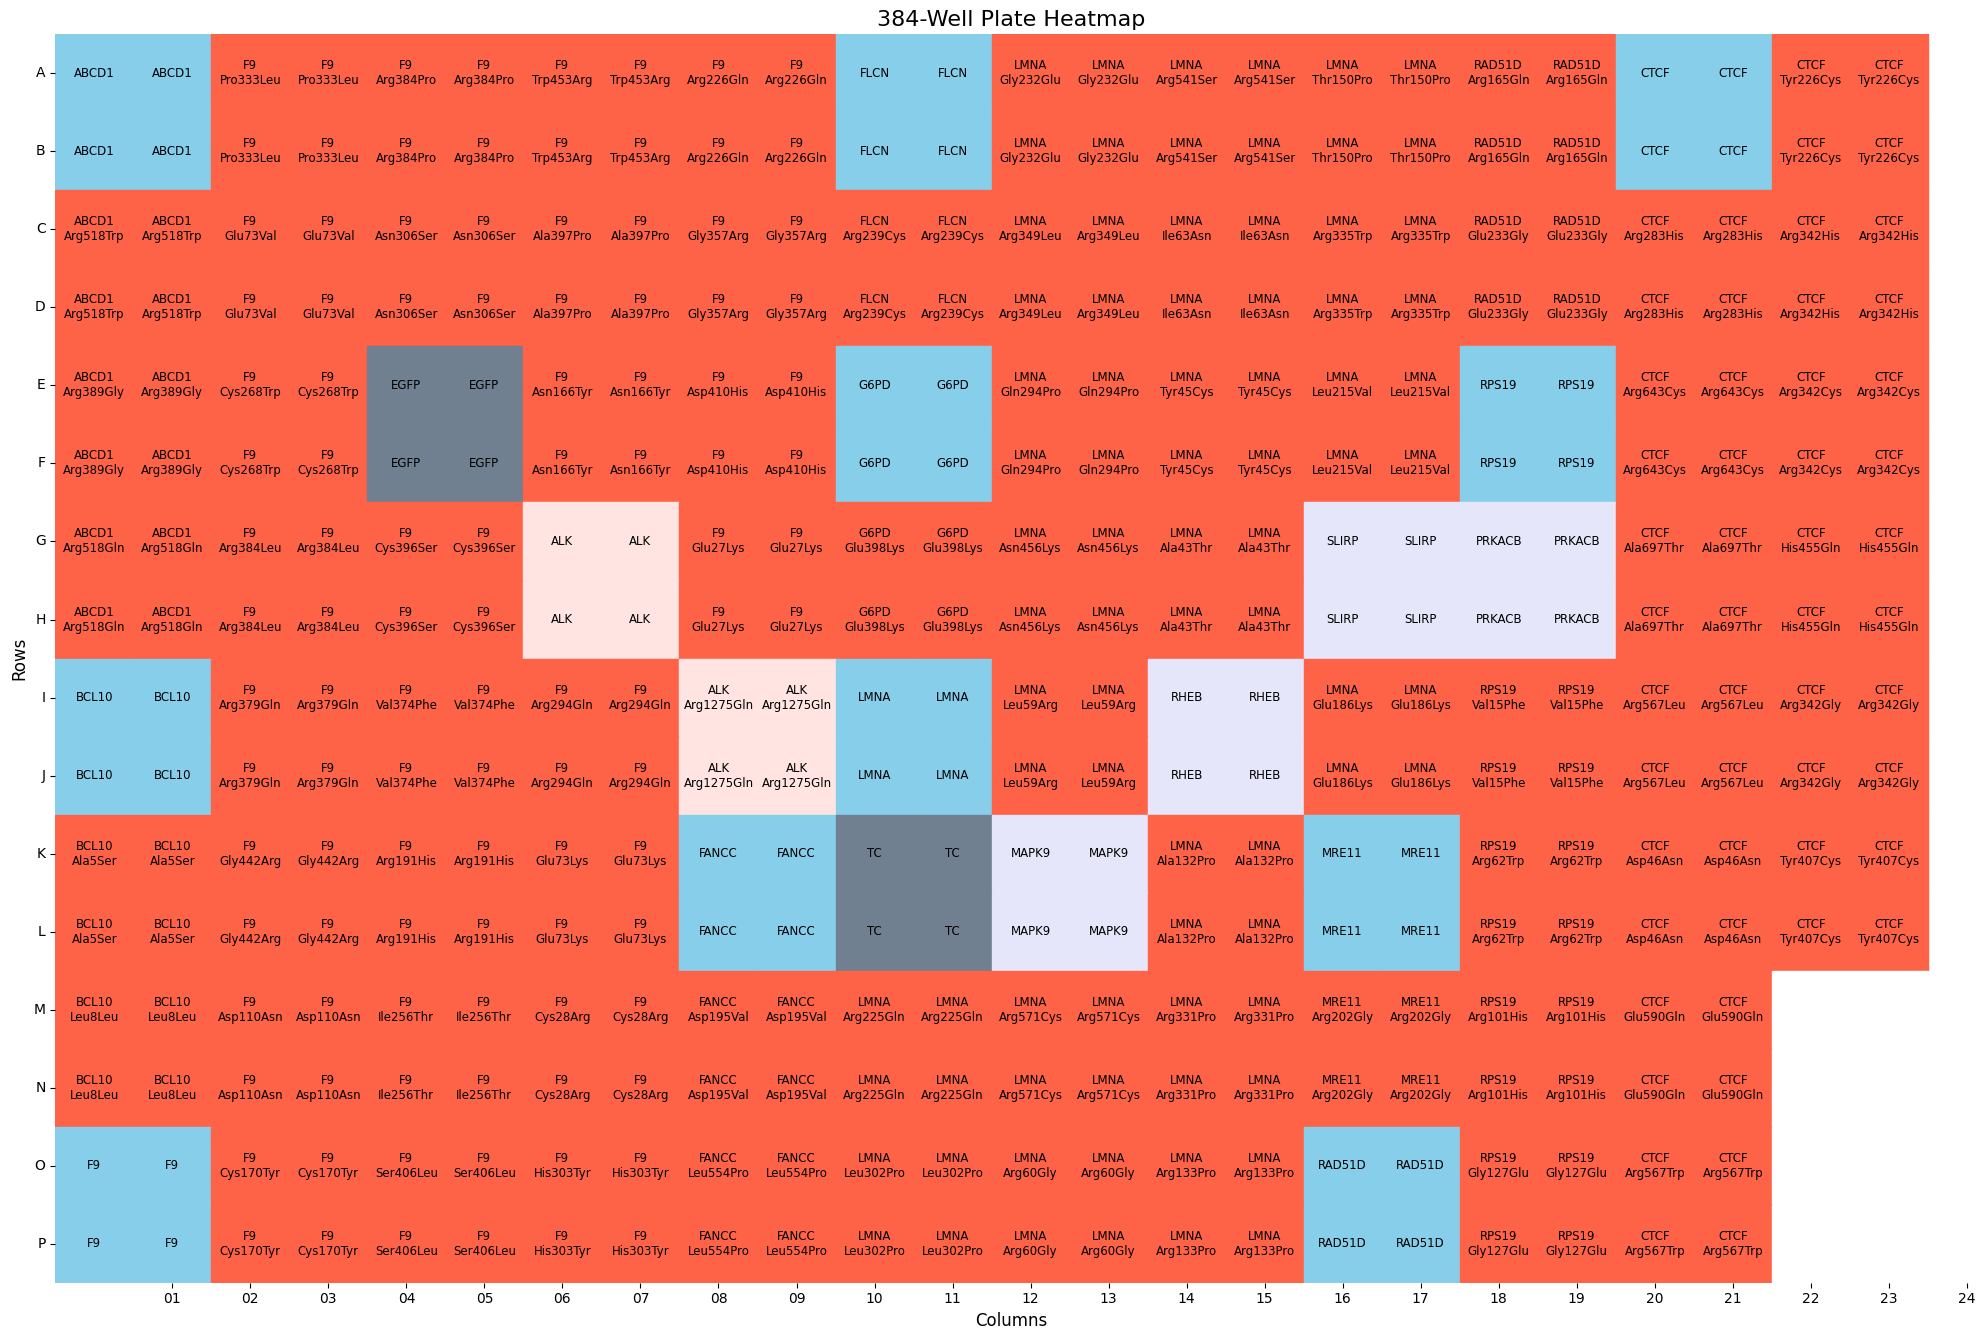

shape: (384, 32)
┌─────┬─────┬───────┬───────────┬───┬────────┬──────────────┬────────────┬───────────┐
│ row ┆ col ┆ value ┆ row_label ┆ … ┆ vector ┆ control_type ┆ color      ┆ label     │
│ --- ┆ --- ┆ ---   ┆ ---       ┆   ┆ ---    ┆ ---          ┆ ---        ┆ ---       │
│ u64 ┆ str ┆ str   ┆ str       ┆   ┆ i64    ┆ str          ┆ str        ┆ str       │
╞═════╪═════╪═══════╪═══════════╪═══╪════════╪══════════════╪════════════╪═══════════╡
│ 0   ┆ 01  ┆       ┆ A         ┆ … ┆ 594    ┆ disease_wt   ┆ disease_wt ┆ ABCD1     │
│ 1   ┆ 01  ┆       ┆ B         ┆ … ┆ 594    ┆ disease_wt   ┆ disease_wt ┆ ABCD1     │
│ 2   ┆ 01  ┆       ┆ C         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ ABCD1     │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Arg518Trp │
│ 3   ┆ 01  ┆       ┆ D         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ ABCD1     │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Arg518Trp │
│ 4   ┆ 01  ┆       ┆ E         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ ABCD1     │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Arg389Gly │
│ …   ┆ …   ┆ …     ┆ …         ┆ … ┆ …      ┆ …            ┆ …          ┆ …         │
│ 11  ┆ 24  ┆       ┆ L         ┆ … ┆ 594    ┆ allele       ┆ allele     ┆ CTCF      │
│     ┆     ┆       ┆           ┆   ┆        ┆              ┆            ┆ Tyr407Cys │
│ 12  ┆ 24  ┆       ┆ M         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 13  ┆ 24  ┆       ┆ N         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 14  ┆ 24  ┆       ┆ O         ┆ … ┆ null   ┆ null         ┆            ┆           │
│ 15  ┆ 24  ┆       ┆ P         ┆ … ┆ null   ┆ null         ┆            ┆           │
└─────┴─────┴───────┴───────────┴───┴────────┴──────────────┴────────────┴───────────┘

In [42]:
batch9_platemap_wf = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/inputs/metadata/platemaps/2024_10_28_Batch_9_widefield/platemap"
plate_map_id2 = "B9A6R1_P01_widefield.txt"
plate_map_2 = pl.read_csv(Path(batch9_platemap_wf) / Path(plate_map_id2), separator='\t', has_header=True)
## Drop a row only if all values are null: 
## (DO NOT use drop_nulls() directly here as it drops all rows with a null in it)
plate_map_2 = plate_map_2.filter(~pl.all_horizontal(pl.all().is_null()))
print(plate_map_2.shape)
column_name = "gene_allele"
plate_map_2 = plate_map_2.with_columns(
    pl.when(pl.col("gene_allele") == "_")  # Condition 1: Keep "_" as is
        .then(pl.col("gene_allele"))
        .when(pl.col("gene_allele").str.ends_with("_") & (pl.col("gene_allele") != "_"))  # Condition 2: Remove trailing "_"
        .then(pl.col("gene_allele").str.replace(r"_$", ""))  # Remove trailing "_"
        .otherwise(pl.col("gene_allele"))  # Keep other values unchanged
        .alias("gene_allele"),  # Replace the original column,
    pl.when(pl.col("gene_allele") == "_")
        .then(pl.col("gene_allele"))
        .when(pl.col("gene_allele").str.contains("_"))
        .then(pl.col("gene_allele").str.extract(r"^(.*?)_", 1))
        .otherwise(pl.col("gene_allele"))
        .alias("symbol"),
    pl.col("node_type").alias("control_type")
    # pl.when(pl.col("gene_allele") == "_")
    #     .then(pl.lit("control"))
    #     .when(pl.col("gene_allele").str.contains("_"))
    #     .then(pl.lit("allele"))
    #     .otherwise(pl.lit("disease_wt"))
    #     .alias("control_type"),
)
# plate_map
# print(plate_map.select(pl.col(column_name).unique()))
# print(plate_map.select(pl.col("gene_allele").unique()))
# # print(plate_map.select(pl.col("symbol").unique()))
plot_platemap(plate_map_2)

In [193]:
# batch10_platemap_dir = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/inputs/metadata/platemaps/2024_10_28_Batch_10_widefield/platemap"
# plate_map_id = "B10A6R2_P01_widefield.txt"
# plate_map = pl.read_csv(Path(batch10_platemap_dir) / Path(plate_map_id), separator='\t', has_header=True)
# plate_map = plate_map.drop_nulls()
# plate_map = plate_map.with_columns(pl.col("node_type").alias("control_type"))
# plot_platemap(plate_map)

## Batch 7/8

shape: (92, 1)
┌────────┐
│ symbol │
│ ---    │
│ str    │
╞════════╡
│ CTRC   │
│ BTC    │
│ EZH2   │
│ RHEB   │
│ ACY1   │
│ …      │
│ COL2A1 │
│ ANKRD1 │
│ ADIPOQ │
│ CREB1  │
│ AGXT   │
└────────┘


shape: (384, 30)
┌───────────┬───────────┬───────────┬─────────┬───────────┬───┬─────┬─────┬──────┬──────┬──────────┐
│ plate_map ┆ well_posi ┆ control_t ┆ symbol  ┆ gene_alle ┆ … ┆ c96 ┆ r96 ┆ r384 ┆ c384 ┆ r384_let │
│ _name     ┆ tion      ┆ ype       ┆ ---     ┆ le        ┆   ┆ --- ┆ --- ┆ ---  ┆ ---  ┆ ter      │
│ ---       ┆ ---       ┆ ---       ┆ str     ┆ ---       ┆   ┆ i64 ┆ i64 ┆ i64  ┆ i64  ┆ ---      │
│ str       ┆ str       ┆ str       ┆         ┆ str       ┆   ┆     ┆     ┆      ┆      ┆ str      │
╞═══════════╪═══════════╪═══════════╪═════════╪═══════════╪═══╪═════╪═════╪══════╪══════╪══════════╡
│ B7A1R1_P1 ┆ A01       ┆ disease_w ┆ ACSF3   ┆ ACSF3     ┆ … ┆ 1   ┆ 1   ┆ 1    ┆ 1    ┆ A        │
│           ┆           ┆ t         ┆         ┆           ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ C01       ┆ allele    ┆ ACSF3   ┆ ACSF3_Ala ┆ … ┆ 1   ┆ 2   ┆ 3    ┆ 1    ┆ C        │
│           ┆           ┆           ┆         ┆ 197Thr    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ E01       ┆ allele    ┆ ACSF3   ┆ ACSF3_Thr ┆ … ┆ 1   ┆ 3   ┆ 5    ┆ 1    ┆ E        │
│           ┆           ┆           ┆         ┆ 358Ile    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ G01       ┆ allele    ┆ ACSF3   ┆ ACSF3_Met ┆ … ┆ 1   ┆ 4   ┆ 7    ┆ 1    ┆ G        │
│           ┆           ┆           ┆         ┆ 198Arg    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ I01       ┆ allele    ┆ ACSF3   ┆ ACSF3_Glu ┆ … ┆ 1   ┆ 5   ┆ 9    ┆ 1    ┆ I        │
│           ┆           ┆           ┆         ┆ 359Lys    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ K01       ┆ allele    ┆ ACSF3   ┆ ACSF3_Ile ┆ … ┆ 1   ┆ 6   ┆ 11   ┆ 1    ┆ K        │
│           ┆           ┆           ┆         ┆ 200Met    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ M01       ┆ allele    ┆ ACSF3   ┆ ACSF3_Ser ┆ … ┆ 1   ┆ 7   ┆ 13   ┆ 1    ┆ M        │
│           ┆           ┆           ┆         ┆ 431Tyr    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ O01       ┆ allele    ┆ ACSF3   ┆ ACSF3_Gly ┆ … ┆ 1   ┆ 8   ┆ 15   ┆ 1    ┆ O        │
│           ┆           ┆           ┆         ┆ 225Arg    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ A03       ┆ allele    ┆ ACSF3   ┆ ACSF3_Asp ┆ … ┆ 2   ┆ 1   ┆ 1    ┆ 3    ┆ A        │
│           ┆           ┆           ┆         ┆ 457Asn    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ C03       ┆ allele    ┆ ACSF3   ┆ ACSF3_Arg ┆ … ┆ 2   ┆ 2   ┆ 3    ┆ 3    ┆ C        │
│           ┆           ┆           ┆         ┆ 10Trp     ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ E03       ┆ allele    ┆ ACSF3   ┆ ACSF3_Asp ┆ … ┆ 2   ┆ 3   ┆ 5    ┆ 3    ┆ E        │
│           ┆           ┆           ┆         ┆ 236Asn    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ G03       ┆ allele    ┆ ACSF3   ┆ ACSF3_Arg ┆ … ┆ 2   ┆ 4   ┆ 7    ┆ 3    ┆ G        │
│           ┆           ┆           ┆         ┆ 471Trp    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ I03       ┆ allele    ┆ ACSF3   ┆ ACSF3_Pro ┆ … ┆ 2   ┆ 5   ┆ 9    ┆ 3    ┆ I        │
│           ┆           ┆           ┆         ┆ 243Leu    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ K03       ┆ allele    ┆ ACSF3   ┆ ACSF3_Gly ┆ … ┆ 2   ┆ 6   ┆ 11   ┆ 3    ┆ K        │
│           ┆           ┆           ┆         ┆ 119Asp    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ M03       ┆ allele    ┆ ACSF3   ┆ ACSF3_Met ┆ … ┆ 2   ┆ 7   ┆ 13   ┆ 3    ┆ M        │
│           ┆           ┆           ┆         ┆ 266Val    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ O03       ┆ allele    ┆ ACSF3   ┆ ACSF3_Pro ┆ … ┆ 2   ┆ 8   ┆ 15   ┆ 3    ┆ O        │
│           ┆           ┆           ┆         ┆ 285Leu    ┆   ┆     ┆     ┆      ┆      ┆          │
│ B7A1R1_P1 ┆ A05       ┆ allele    ┆ ACSF3   ┆ ACSF3_Glu ┆ … ┆ 3   ┆ 1   ┆ 1    ┆ 5    ┆ A        │
│           ┆           ┆           ┆       

Number of unique alleles: ['AGXT_Met49Leu', 'ALAS2_Asp122Asn', 'ACSF3_Ile200Met', 'DES_Thr453Ile', 'DES_Met349Ile', 'AGXT_Arg301Cys', 'DES_Ala135Val', 'ADIPOQ', 'AGXT', 'AIPL1_Thr114Ile', 'AQP1', 'ACSF3', 'COMP_Asp319Val', 'AGXT_Ala186Val', 'CORO1A', 'ACSF3_Ser431Tyr', 'CYP21A2', 'AGXT_Ala85Asp', 'ALAS2_Ala135Thr', 'AGXT_Asp341Glu', 'ALAS2', 'COMP_Asp408Asn', 'DES_Ser46Tyr', 'BRIP1', 'EFHC1_Ile174Val', 'ALOX5', 'CTRC_Glu225Ala', 'AGXT_Arg197Gln', 'AGXT_Ala248Val', 'AIPL1_Met79Thr', 'CRYAB_Gly154Ser', 'AGXT_Asp129His', 'APOA1_Ala199Pro', 'EMD_Asp72Val', 'CBR3', 'ACSF3_Gly225Arg', 'DCX_Lys174Glu', 'AGXT_Ile202Asn', 'DES_Val56Leu', 'APOA1_Trp74Arg', 'AGXT_Leu298Pro', 'AGXT_Met195Leu', 'COMP_Thr585Met', 'DMC1', 'DCX_Arg89Gly', 'BLMH_Ile443Val', 'DES_Tyr331Asn', 'AMPD2', 'ACSF3_Arg558Trp', 'FADD_Cys105Trp', 'EMD_Met1Val', 'EIF2B4', 'ALAS2_Phe128Leu', 'DES_Pro433Thr', 'ACSF3_Ala197Thr', 'AGXT_Gly161Arg', 'DES_Gln389Pro', 'ACSF3_Arg471Trp', 'AGXT_Ser221Pro', 'EIF2B4_Ala228Val', 'ANKRD1', 'CLD

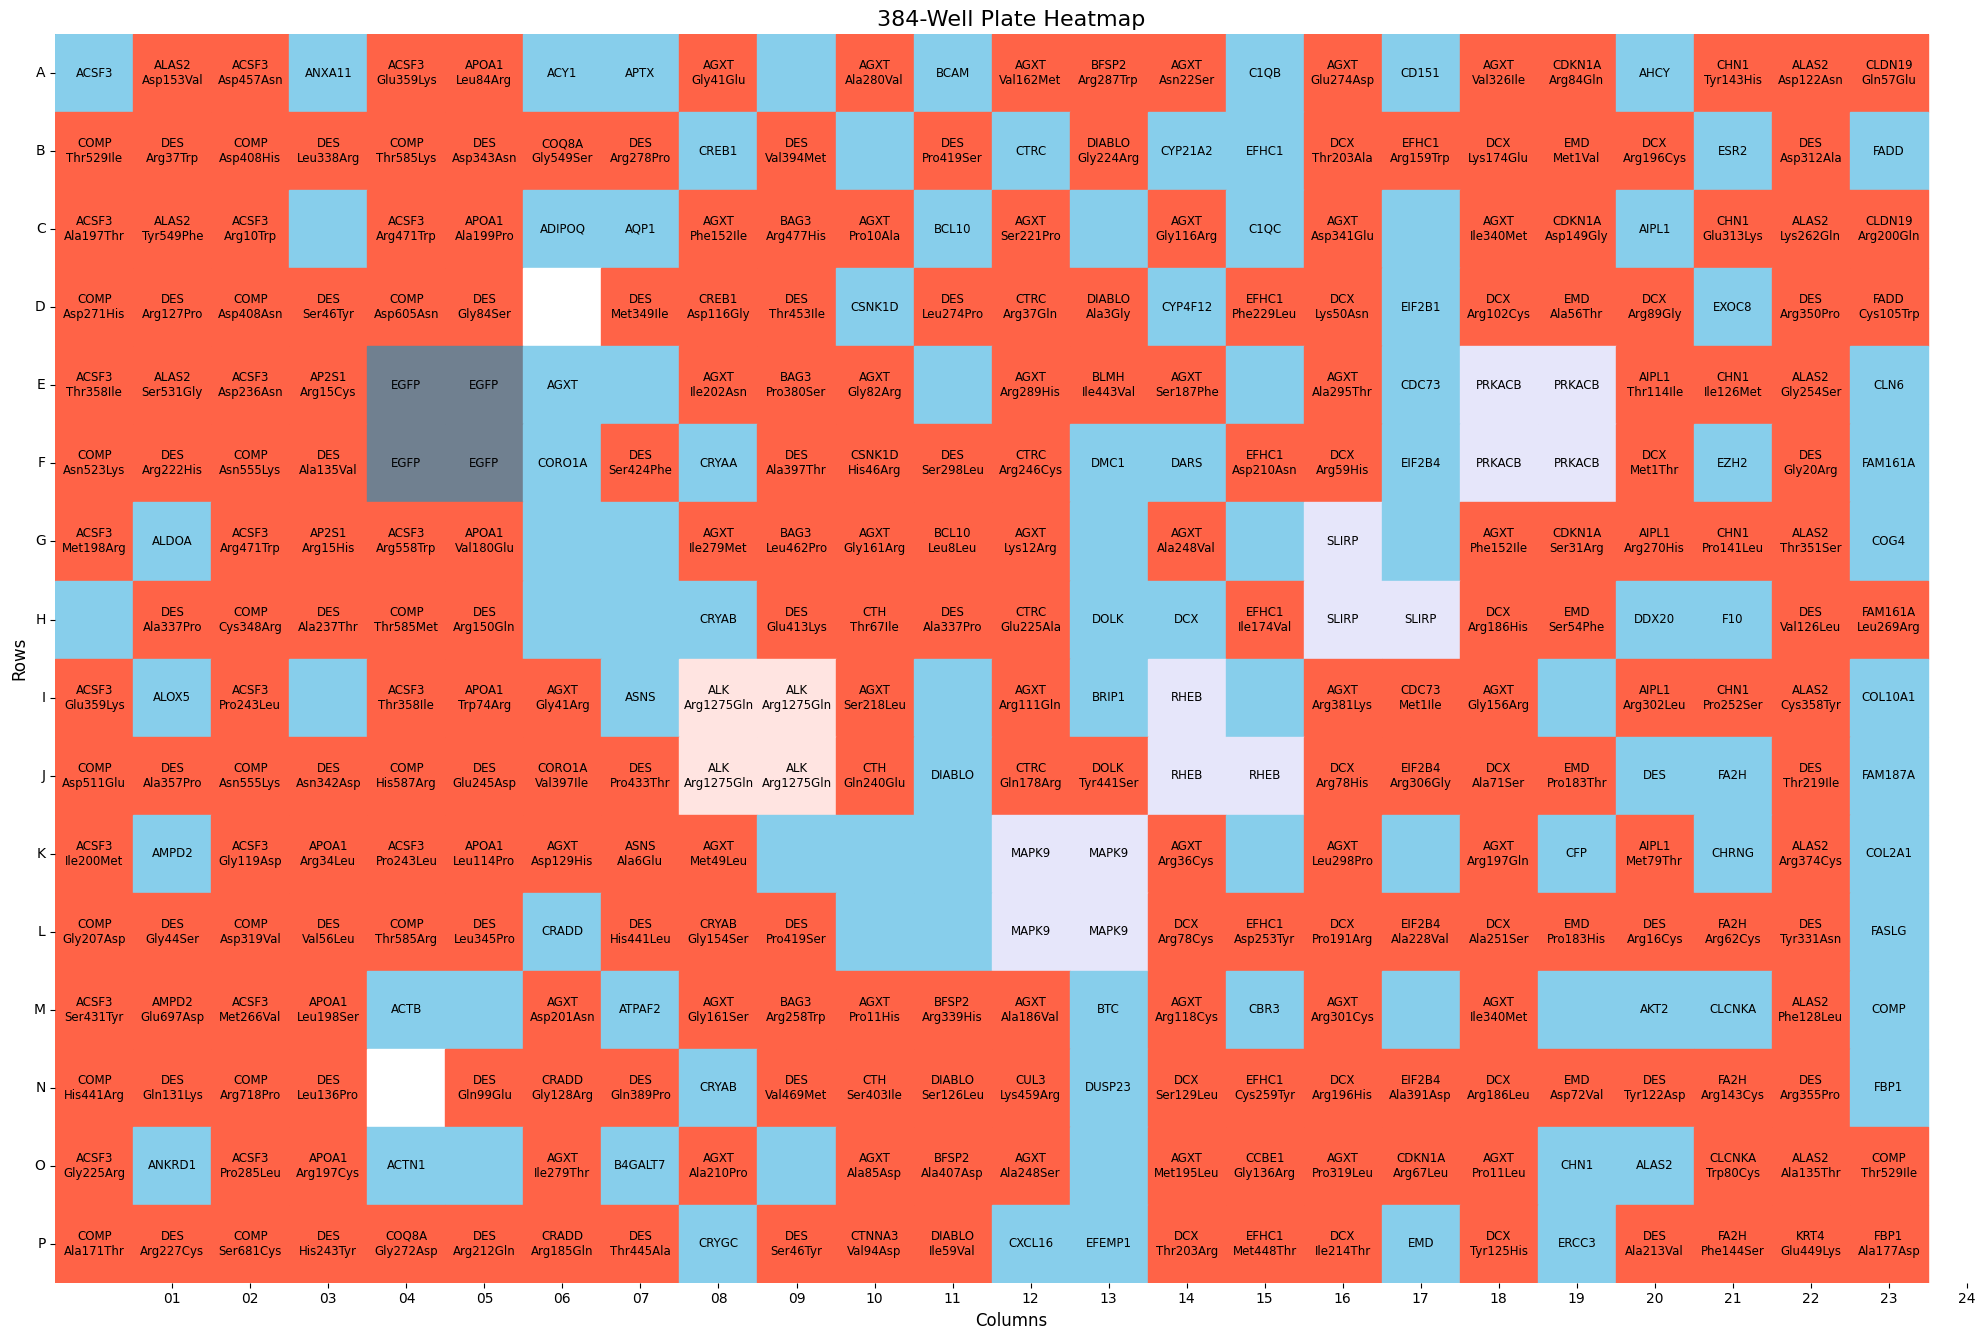

shape: (384, 37)
┌─────┬─────┬───────┬───────────┬───────────┬───┬──────┬──────┬────────────┬───────────┬───────────┐
│ row ┆ col ┆ value ┆ row_label ┆ col_label ┆ … ┆ r384 ┆ c384 ┆ r384_lette ┆ color     ┆ label     │
│ --- ┆ --- ┆ ---   ┆ ---       ┆ ---       ┆   ┆ ---  ┆ ---  ┆ r          ┆ ---       ┆ ---       │
│ u64 ┆ str ┆ str   ┆ str       ┆ str       ┆   ┆ i64  ┆ i64  ┆ ---        ┆ str       ┆ str       │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆ str        ┆           ┆           │
╞═════╪═════╪═══════╪═══════════╪═══════════╪═══╪══════╪══════╪════════════╪═══════════╪═══════════╡
│ 0   ┆ 01  ┆       ┆ A         ┆ 01        ┆ … ┆ 1    ┆ 1    ┆ A          ┆ disease_w ┆ ACSF3     │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆ t         ┆           │
│ 1   ┆ 01  ┆       ┆ B         ┆ 01        ┆ … ┆ 2    ┆ 1    ┆ B          ┆ allele    ┆ COMP      │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Thr529Ile │
│ 2   ┆ 01  ┆       ┆ C         ┆ 01        ┆ … ┆ 3    ┆ 1    ┆ C          ┆ allele    ┆ ACSF3     │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Ala197Thr │
│ 3   ┆ 01  ┆       ┆ D         ┆ 01        ┆ … ┆ 4    ┆ 1    ┆ D          ┆ allele    ┆ COMP      │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Asp271His │
│ 4   ┆ 01  ┆       ┆ E         ┆ 01        ┆ … ┆ 5    ┆ 1    ┆ E          ┆ allele    ┆ ACSF3     │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Thr358Ile │
│ 5   ┆ 01  ┆       ┆ F         ┆ 01        ┆ … ┆ 6    ┆ 1    ┆ F          ┆ allele    ┆ COMP      │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Asn523Lys │
│ 6   ┆ 01  ┆       ┆ G         ┆ 01        ┆ … ┆ 7    ┆ 1    ┆ G          ┆ allele    ┆ ACSF3     │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Met198Arg │
│ 7   ┆ 01  ┆       ┆ H         ┆ 01        ┆ … ┆ 8    ┆ 1    ┆ H          ┆ disease_w ┆           │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆ t         ┆           │
│ 8   ┆ 01  ┆       ┆ I         ┆ 01        ┆ … ┆ 9    ┆ 1    ┆ I          ┆ allele    ┆ ACSF3     │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Glu359Lys │
│ 9   ┆ 01  ┆       ┆ J         ┆ 01        ┆ … ┆ 10   ┆ 1    ┆ J          ┆ allele    ┆ COMP      │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Asp511Glu │
│ 10  ┆ 01  ┆       ┆ K         ┆ 01        ┆ … ┆ 11   ┆ 1    ┆ K          ┆ allele    ┆ ACSF3     │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Ile200Met │
│ 11  ┆ 01  ┆       ┆ L         ┆ 01        ┆ … ┆ 12   ┆ 1    ┆ L          ┆ allele    ┆ COMP      │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Gly207Asp │
│ 12  ┆ 01  ┆       ┆ M         ┆ 01        ┆ … ┆ 13   ┆ 1    ┆ M          ┆ allele    ┆ ACSF3     │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Ser431Tyr │
│ 13  ┆ 01  ┆       ┆ N         ┆ 01        ┆ … ┆ 14   ┆ 1    ┆ N          ┆ allele    ┆ COMP      │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ His441Arg │
│ 14  ┆ 01  ┆       ┆ O         ┆ 01        ┆ … ┆ 15   ┆ 1    ┆ O          ┆ allele    ┆ ACSF3     │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Gly225Arg │
│ 15  ┆ 01  ┆       ┆ P         ┆ 01        ┆ … ┆ 16   ┆ 1    ┆ P          ┆ allele    ┆ COMP      │
│     ┆     ┆       ┆           ┆           ┆   ┆      ┆      ┆            ┆           ┆ Ala171Thr │
│ 0   ┆ 02  ┆       ┆ A         ┆ 02        ┆ … ┆ 1    ┆ 2    ┆ A          ┆ allele    ┆ ALAS2     │
│     ┆     ┆       ┆           ┆           

In [45]:
batch7_platemap_dir = "/home/shenrunx/igvf/varchamp/2021_09_01_VarChAMP/7.analysis_runxi/output/meta_correct_batch78/2024_01_23_Batch_7"
plate7_map_id = "B7A1R1_P1.txt"
plate7_map = pl.read_csv(Path(batch7_platemap_dir) / Path(plate7_map_id), separator='\t', has_header=True)
print(plate7_map.select(pl.col("symbol").unique()))

pl.Config.set_tbl_rows(200)  # Show all rows
pl.Config.set_tbl_cols(10)  # Show all columns
display(plate7_map)
# print("Number of unique alleles:", plate7_map.select(pl.col("gene_allele").unique()))
plate7_map.head() #  = plate_map.drop_nulls()
# print(plate7_map.filter(pl.col("symbol").is_in(TC+NC+PC+cNC+cPC) | pl.col("gene_allele").is_in(TC+NC+PC+cNC+cPC)))
# print(plate7_map.filter(pl.col("symbol").is_in(TC+NC+PC+cNC+cPC)))
plot_platemap(plate7_map)

In [34]:
# plate7_map.filter(pl.col("well_position")=="N05")